In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from src.stations import Stations
from src.track import Track, TrackCollection
from src.solvers import SingleStationSolver

from tqdm import tqdm
import json

%matplotlib inline

In [3]:
## Training data
df = (pd.read_csv('data/round2_competition.csv')
      .assign(test = lambda x: x.latitude.apply(lambda y: int(np.isnan(y))))
      .loc[lambda x: x.test==0]
      .reset_index(drop=True)
     )

tracks = TrackCollection(df)

100%|██████████| 2629/2629 [06:26<00:00,  6.80it/s]


In [5]:
# Download stations parameters calculated previously

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

# A0 and B values from optimization of 35 good stations
A0_B = [pow(10, y) for y in [-3.43667365e+00, -4.06472353e+00]]
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

## Method description

We will synchronize stations in many rounds starting with the closest ones to 36 synchronized.
Each round candidates for synchronization will be found using *find_new_stations* method of *SingleStationSolver* class. Then, for each candidate a subset of points will be prepared and station's location and drift will be optimized. If optimization shows less than 35m median error and no large time gaps, such a station will be added to a pool of syncronized ones. And so on.

Initially we will start with candidates having at least 3 pairs with synchronized stations each of which having at least 1000 points. Later we will have to reduce these constrains in order to add more stations.

Stations showing more than 100m median error will be marked as bad stations and removed from synchronization process. Stations showing more than 35m and less than 100m will be synchronized later when all good candidates are picked out.

In this notebook I'm using a list of bad stations from the beginning to reduce computation time, which is about ... hours even in this case. 

## First run

In [7]:
# Completely bad stations
bad = [205, 259, 296, 222, 207, 695, 700, 525, 699, 461,
       605, 295, 671, 377, 577, 641, 312, 702, 214, 635,
       281, 477, 220]

# Will add these in the end
last_order = [265, 346, 478, 439, 619, 423, 623, 357]

In [8]:
sss = SingleStationSolver()
sss.find_new_stations(tracks, st, bad + last_order, N=1000)

100%|██████████| 2629/2629 [00:00<00:00, 2884.87it/s]


{197: [(197, 208)],
 184: [(184, 208), (184, 216)],
 228: [(208, 228)],
 434: [(150, 434)],
 552: [(150, 552)],
 481: [(143, 481), (149, 481), (141, 481)],
 590: [(143, 590), (149, 590)],
 260: [(143, 260), (149, 260)],
 607: [(143, 607)],
 627: [(133, 627)],
 678: [(263, 678), (141, 678), (143, 678)],
 586: [(143, 586), (149, 586)],
 297: [(143, 297), (149, 297)],
 310: [(310, 474), (147, 310), (310, 632), (14, 310), (10, 310)],
 183: [(183, 460), (183, 414), (183, 663)],
 363: [(363, 550), (363, 414), (130, 363)],
 499: [(470, 499), (147, 499), (14, 499), (474, 499), (121, 499)],
 231: [(208, 231), (216, 231)],
 471: [(10, 471), (470, 471), (147, 471), (471, 632), (471, 474), (14, 471)],
 248: [(248, 398), (248, 670), (134, 248)],
 366: [(366, 398), (366, 670)],
 142: [(142, 143)],
 166: [(143, 166)],
 513: [(513, 569), (513, 564), (513, 568), (136, 513), (402, 513)],
 163: [(163, 564), (163, 569), (136, 163)],
 560: [(257, 560)],
 457: [(208, 457)],
 595: [(208, 595), (216, 595)],
 

In [13]:
for j in tqdm(sss.new_stations):
    # if less than 3 pairs with other stations
    if len(sss.new_stations[j]) < 3:
        continue
            
    if j in bad or j in last_order:
        continue
        
    st.add_station(j)
    sss.prepare_data(tracks, st, j, 20000)
    
    if sss.points['t1'].shape[0] < 20000:
        print(f'Station {j} has less than 20000 points, skip')
        continue
        
    sss.optimize()
    if sss.med_error < 35 and sss.max_dt_gap < 25:
        sss.save('stations_params2.json')
        print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
        sss.prepare_data(tracks, st, j, 20000)
        sss.optimize()
        sss.save('stations_params3.json')
        print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
        sss.prepare_data(tracks, st, j, 20000)
        sss.optimize()
        sss.save('stations_params4.json')
        print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
    elif sss.med_error < 35:
        print(f'Station {j}: Large time gap of {sss.max_dt_gap}, skip')
    else:
        print(f'Bad station: {j}: error={sss.med_error:.4}m')
        
# Save best result from three runs
with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)

with open('stations_params2.json', 'r') as f:  
    st_params2 = json.load(f)
    
with open('stations_params3.json', 'r') as f:  
    st_params3 = json.load(f)
    
with open('stations_params4.json', 'r') as f:  
    st_params4 = json.load(f)
    
for s in st_params2:
    if st_params2[s]['med_error'] <= min(st_params3[s]['med_error'], st_params4[s]['med_error']):
        st_params[s] = st_params2[s]
    elif st_params3[s]['med_error'] <= min(st_params2[s]['med_error'], st_params4[s]['med_error']):
        st_params[s] = st_params3[s]
    else:
        st_params[s] = st_params4[s]
        
with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)
    
# remove temporary files
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/68 [00:00<?, ?it/s]

Good station 481: error=18.45m, distance=50.19m
Good station 481: error=18.44m, distance=0.7507m


  9%|▉         | 6/68 [01:17<13:21, 12.92s/it]

Good station 481: error=18.44m, distance=1.051m


 16%|█▌        | 11/68 [01:53<09:18,  9.81s/it]

Station 678: Large time gap of 44.54687062968725, skip
Good station 310: error=18.51m, distance=7.064m
Good station 310: error=18.43m, distance=0.3133m


 21%|██        | 14/68 [11:14<59:31, 66.13s/it]

Good station 310: error=18.57m, distance=1.714m
Good station 183: error=22.94m, distance=28.91m
Good station 183: error=23.0m, distance=0.1159m


 22%|██▏       | 15/68 [12:16<57:54, 65.55s/it]

Good station 183: error=23.1m, distance=0.7385m
Good station 363: error=19.55m, distance=14.72m
Good station 363: error=19.49m, distance=0.06263m


 24%|██▎       | 16/68 [13:17<56:14, 64.90s/it]

Good station 363: error=19.5m, distance=1.051m
Good station 499: error=16.91m, distance=72.62m
Good station 499: error=16.92m, distance=1.022m


 25%|██▌       | 17/68 [14:36<57:17, 67.41s/it]

Good station 499: error=16.89m, distance=0.9105m
Good station 471: error=20.47m, distance=11.1m
Good station 471: error=20.4m, distance=1.097m


 28%|██▊       | 19/68 [16:16<50:11, 61.46s/it]

Good station 471: error=20.45m, distance=1.486m
Good station 248: error=18.3m, distance=41.83m
Good station 248: error=18.32m, distance=1.391m


 29%|██▉       | 20/68 [17:28<50:52, 63.59s/it]

Good station 248: error=18.31m, distance=0.5503m
Good station 513: error=18.06m, distance=21.29m
Good station 513: error=18.02m, distance=1.532m


 35%|███▌      | 24/68 [18:54<30:16, 41.28s/it]

Good station 513: error=18.05m, distance=1.251m
Good station 163: error=26.03m, distance=14.21m
Good station 163: error=25.98m, distance=1.873m


 37%|███▋      | 25/68 [20:04<32:45, 45.71s/it]

Good station 163: error=26.02m, distance=1.125m
Good station 466: error=18.62m, distance=25.38m
Good station 466: error=18.65m, distance=0.9061m


 44%|████▍     | 30/68 [21:21<18:46, 29.65s/it]

Good station 466: error=18.68m, distance=0.3961m
Good station 642: error=13.22m, distance=3.901m
Good station 642: error=13.23m, distance=0.07549m


 54%|█████▍    | 37/68 [22:15<09:28, 18.35s/it]

Good station 642: error=13.24m, distance=0.7388m
Good station 645: error=19.02m, distance=2.012m
Good station 645: error=19.02m, distance=1.129m


 57%|█████▋    | 39/68 [23:03<09:20, 19.33s/it]

Good station 645: error=19.03m, distance=1.755m
Good station 422: error=19.0m, distance=10.06m
Good station 422: error=19.01m, distance=0.6584m


 76%|███████▋  | 52/68 [24:09<02:48, 10.53s/it]

Good station 422: error=19.0m, distance=0.2931m
Good station 421: error=21.33m, distance=4.122m
Good station 421: error=21.27m, distance=1.035m


 78%|███████▊  | 53/68 [25:12<03:27, 13.86s/it]

Good station 421: error=21.21m, distance=0.2116m


100%|██████████| 68/68 [26:09<00:00, 23.08s/it]

Station 455: Large time gap of 121.74133215451604, skip


###  Station 678

In [22]:
sss.prepare_data(tracks, st, 678, 20000)
sss.optimize()

Median error: 23.69m using s=2e-12
Max time gap: 44.88s
Delta distance: 0.1121m


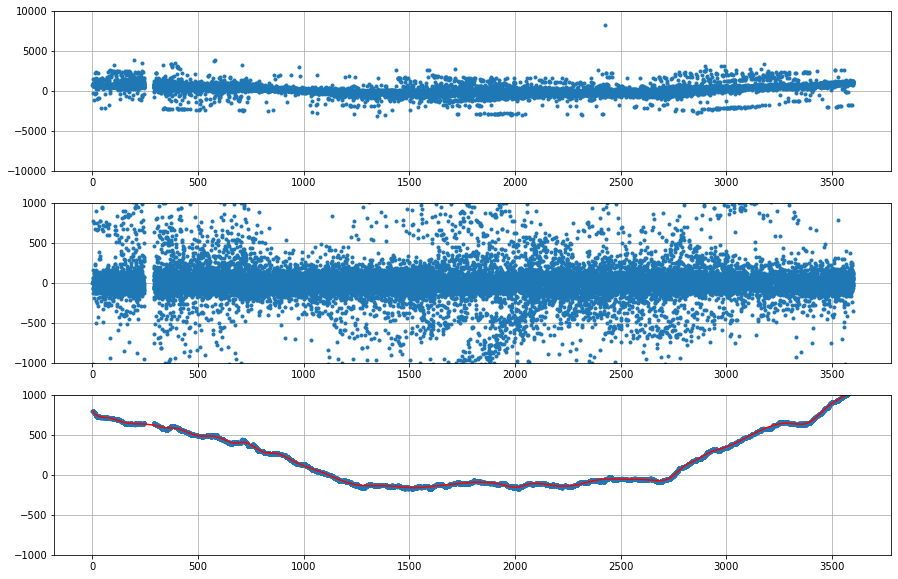

In [23]:
sss.check_result()

In [24]:
sss.save()

###  Station 455

In [29]:
sss.prepare_data(tracks, st, 455, 20000)
sss.optimize()

Median error: 23.04m using s=2e-12
Max time gap: 121.2s
Delta distance: 1.636m


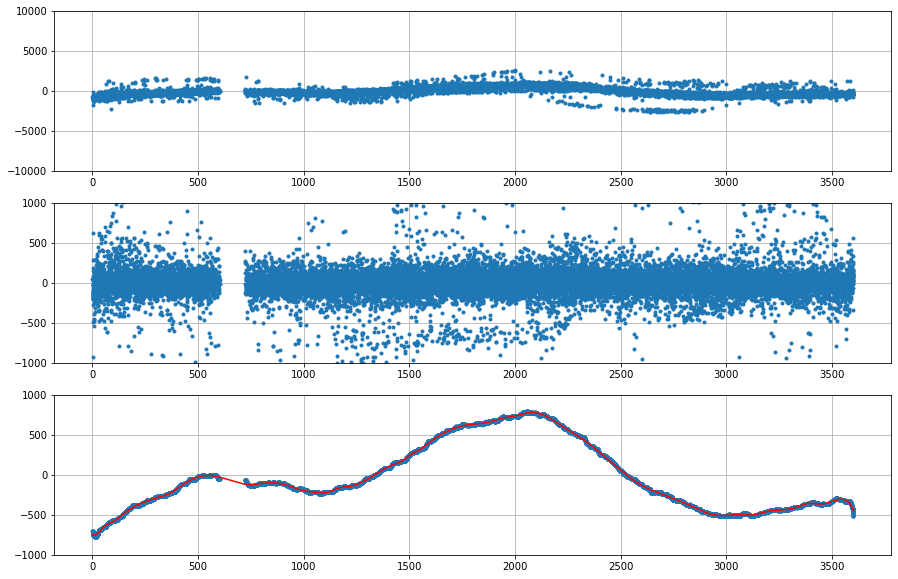

In [30]:
sss.check_result()

In [31]:
sss.save()

## Many many runs

In [32]:
def another_run(Nsearch=1000, bad=[], future=[], max_err=35, N=20000, n_new_stations=3):
    ## Prepare stations
    with open('stations_params.json', 'r') as f:  
        st_params = json.load(f)

    st = Stations([int(s) for s in st_params])
    st.A0 = A0_B[0]
    st.B = A0_B[1]

    for s in st_params:
        st.update_location(int(s), st_params[s]['location'])

    st.st_params = st_params

    ## Find new stations
    sss = SingleStationSolver()
    sss.find_new_stations(tracks, st, bad+future, N=Nsearch)

    for j in tqdm(sss.new_stations):
    
        if (j in bad) or (j in future):
            continue

        if len(sss.new_stations[j]) < n_new_stations:
            continue

        st.add_station(j)
        sss.prepare_data(tracks, st, j, N)

        if sss.points['t1'].shape[0] < N:
            print(f'Station {j} has less than {N} points, skip')
            continue

        sss.optimize()
        if sss.med_error < max_err and sss.max_dt_gap < 25:
            sss.save('stations_params2.json')
            print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')

            sss.prepare_data(tracks, st, j, 20000)
            sss.optimize()
            sss.save('stations_params3.json')
            print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')

            sss.prepare_data(tracks, st, j, 20000)
            sss.optimize()
            sss.save('stations_params4.json')
            print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
        elif sss.med_error < max_err:
            print(f'Station {j}: Large time gap of {sss.max_dt_gap:.4}, error {sss.med_error:.4}m, skip')
        
        else:
            print(f'Bad station: {j}: error={sss.med_error:.4}m')
        
    # Save best result
    with open('stations_params2.json', 'r') as f:  
        st_params2 = json.load(f)

    with open('stations_params3.json', 'r') as f:  
        st_params3 = json.load(f)

    with open('stations_params4.json', 'r') as f:  
        st_params4 = json.load(f)

    for s in st_params2:
        if st_params2[s]['med_error'] <= min(st_params3[s]['med_error'], st_params4[s]['med_error']):
            st_params[s] = st_params2[s]
        elif st_params3[s]['med_error'] <= min(st_params2[s]['med_error'], st_params4[s]['med_error']):
            st_params[s] = st_params3[s]
        else:
            st_params[s] = st_params4[s]

    with open('stations_params.json', 'w') as f:
        json.dump(st_params, f)

    
    print('Number of synchronized stations=', len(st_params))
    return sss

In [33]:
# stations to synchronize later (usually having > 35m median error)
future = []

sss = another_run(1000, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/53 [00:00<?, ?it/s]

Good station 184: error=21.03m, distance=22.98m
Good station 184: error=21.03m, distance=0.9254m


  4%|▍         | 2/53 [01:30<38:37, 45.44s/it]

Good station 184: error=21.02m, distance=0.2554m
Good station 590: error=18.34m, distance=2.746m
Good station 590: error=18.5m, distance=1.379m


 11%|█▏        | 6/53 [03:27<26:09, 33.40s/it]

Good station 590: error=18.36m, distance=1.079m
Good station 260: error=19.63m, distance=20.72m
Good station 260: error=19.58m, distance=0.7826m


 13%|█▎        | 7/53 [05:03<35:41, 46.56s/it]

Good station 260: error=19.57m, distance=0.3962m
Good station 586: error=21.15m, distance=33.35m
Good station 586: error=21.1m, distance=2.394m


 19%|█▉        | 10/53 [14:41<1:22:48, 115.54s/it]

Good station 586: error=20.89m, distance=0.81m
Good station 297: error=26.11m, distance=18.75m
Good station 297: error=26.11m, distance=0.9558m


 21%|██        | 11/53 [24:43<2:23:24, 204.88s/it]

Good station 297: error=25.95m, distance=0.3573m
Good station 366: error=20.3m, distance=14.48m
Good station 366: error=20.42m, distance=0.6837m


 25%|██▍       | 13/53 [25:59<1:38:21, 147.55s/it]

Good station 366: error=20.37m, distance=0.6716m
Good station 185: error=16.41m, distance=11.18m
Good station 185: error=16.37m, distance=1.007m


 36%|███▌      | 19/53 [27:33<39:02, 68.89s/it]   

Good station 185: error=16.39m, distance=0.6967m
Good station 169: error=21.63m, distance=4.728m
Good station 169: error=21.64m, distance=1.979m


 40%|███▉      | 21/53 [28:55<33:27, 62.72s/it]

Good station 169: error=nanm, distance=nanm
Good station 277: error=34.11m, distance=15.84m
Good station 277: error=34.24m, distance=1.269m


100%|██████████| 53/53 [30:14<00:00, 34.25s/it]

Good station 277: error=34.27m, distance=1.145m
Number of synchronized stations= 61


In [35]:
sss = another_run(1000, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/48 [00:00<?, ?it/s]

Good station 228: error=23.36m, distance=9.926m
Good station 228: error=23.28m, distance=0.06578m


  4%|▍         | 2/48 [00:50<19:21, 25.24s/it]

Good station 228: error=23.38m, distance=0.9154m
Good station 607: error=19.66m, distance=22.91m
Good station 607: error=19.61m, distance=0.5202m


 10%|█         | 5/48 [01:59<17:02, 23.79s/it]

Good station 607: error=19.69m, distance=0.173m
Good station 231: error=19.57m, distance=6.201m
Good station 231: error=19.6m, distance=0.2846m


 15%|█▍        | 7/48 [03:40<23:27, 34.33s/it]

Good station 231: error=19.59m, distance=0.7122m
Good station 595: error=26.66m, distance=19.22m
Good station 595: error=26.6m, distance=1.59m


 25%|██▌       | 12/48 [04:59<14:02, 23.40s/it]

Good station 595: error=26.65m, distance=0.8586m
Good station 677: error=19.78m, distance=15.33m
Good station 677: error=19.66m, distance=0.3652m


 29%|██▉       | 14/48 [06:28<16:19, 28.80s/it]

Good station 677: error=19.7m, distance=0.1779m
Good station 491: error=19.4m, distance=8.885m
Good station 491: error=19.45m, distance=0.4722m


100%|██████████| 48/48 [07:48<00:00,  9.76s/it]

Good station 491: error=19.41m, distance=0.4977m
Number of synchronized stations= 67


In [36]:
sss = another_run(1000, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/42 [00:00<?, ?it/s]

Good station 197: error=21.61m, distance=26.52m
Good station 197: error=21.6m, distance=0.6605m


  2%|▏         | 1/42 [01:44<1:11:07, 104.09s/it]

Good station 197: error=21.59m, distance=0.1778m
Good station 457: error=20.27m, distance=16.43m
Good station 457: error=20.25m, distance=0.658m


 19%|█▉        | 8/42 [03:17<12:13, 21.57s/it]   

Good station 457: error=20.29m, distance=0.8415m
Good station 269: error=21.63m, distance=271.9m
Good station 269: error=21.9m, distance=1.17m


 21%|██▏       | 9/42 [04:46<17:43, 32.23s/it]

Good station 269: error=21.75m, distance=1.336m
Good station 279: error=20.13m, distance=26.58m
Good station 279: error=20.11m, distance=2.089m


 24%|██▍       | 10/42 [05:58<21:00, 39.40s/it]

Good station 279: error=20.15m, distance=1.382m


100%|██████████| 42/42 [06:32<00:00,  9.35s/it]

Station 657: Large time gap of 208.5, error 22.3m, skip
Number of synchronized stations= 71


###  Station 657

In [38]:
with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)

st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])

st.st_params = st_params
st.add_station(657)

sss.prepare_data(tracks, st, 657, 20000)
sss.optimize()

Median error: 22.11m using s=1.55e-11
Max time gap: 208.3s
Delta distance: 17.83m


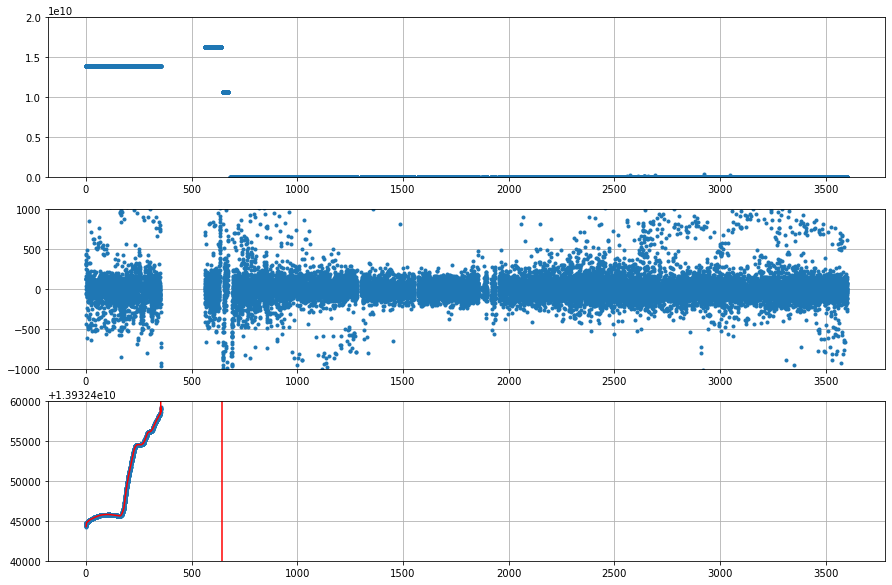

In [39]:
sss.check_result(ylim1=[-1e5, 2e10], ylim3=[1.393244e10, 1.393246e10])

In [40]:
sss.save()

In [41]:
# As there are no new stations, reduce the number of points per pair from 1000 to 800

sss = another_run(800, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/64 [00:00<?, ?it/s]

Good station 627: error=27.46m, distance=66.83m
Good station 627: error=27.49m, distance=0.9669m


  6%|▋         | 4/64 [01:06<16:42, 16.71s/it]

Good station 627: error=27.48m, distance=0.4342m
Good station 359: error=22.91m, distance=309.4m
Good station 359: error=22.83m, distance=1.53m


  9%|▉         | 6/64 [02:23<24:57, 25.81s/it]

Good station 359: error=22.91m, distance=0.8315m
Good station 634: error=22.48m, distance=68.58m
Good station 634: error=22.5m, distance=0.9588m


 16%|█▌        | 10/64 [03:22<17:45, 19.74s/it]

Good station 634: error=22.5m, distance=0.8054m
Good station 388: error=25.61m, distance=6.121m
Good station 388: error=25.52m, distance=0.02071m


 17%|█▋        | 11/64 [05:00<28:37, 32.40s/it]

Good station 388: error=25.57m, distance=1.017m
Good station 706: error=16.59m, distance=16.27m
Good station 706: error=16.56m, distance=0.7345m


 19%|█▉        | 12/64 [06:08<33:57, 39.18s/it]

Good station 706: error=16.54m, distance=0.6498m
Good station 490: error=24.68m, distance=14.38m
Good station 490: error=24.72m, distance=0.5816m


 22%|██▏       | 14/64 [07:12<30:30, 36.60s/it]

Good station 490: error=24.52m, distance=2.792m
Good station 560: error=26.08m, distance=8.841m
Good station 560: error=26.03m, distance=0.9696m


 28%|██▊       | 18/64 [08:36<22:04, 28.79s/it]

Good station 560: error=26.06m, distance=1.868m
Good station 158: error=25.84m, distance=465.9m
Good station 158: error=25.97m, distance=1.262m


 34%|███▍      | 22/64 [09:54<17:30, 25.00s/it]

Good station 158: error=25.96m, distance=0.8948m
Good station 156: error=27.18m, distance=466.3m
Good station 156: error=27.3m, distance=0.9332m


 36%|███▌      | 23/64 [11:05<21:07, 30.92s/it]

Good station 156: error=27.31m, distance=1.4m
Good station 429: error=22.41m, distance=15.5m
Good station 429: error=22.45m, distance=1.569m


 38%|███▊      | 24/64 [12:20<25:10, 37.77s/it]

Good station 429: error=22.39m, distance=2.893m
Good station 521: error=19.87m, distance=1.012e+03m
Good station 521: error=19.94m, distance=0.8467m


 39%|███▉      | 25/64 [14:00<31:58, 49.19s/it]

Good station 521: error=19.94m, distance=0.867m
Good station 131: error=22.87m, distance=4.096m
Good station 131: error=22.82m, distance=0.4674m


 41%|████      | 26/64 [14:55<31:53, 50.34s/it]

Good station 131: error=22.94m, distance=1.354m
Good station 358: error=20.86m, distance=36.31m
Good station 358: error=20.83m, distance=0.813m


 47%|████▋     | 30/64 [15:47<17:05, 30.15s/it]

Good station 358: error=20.83m, distance=0.4985m
Good station 532: error=17.89m, distance=55.19m
Good station 532: error=17.88m, distance=0.454m


 53%|█████▎    | 34/64 [18:02<15:49, 31.65s/it]

Good station 532: error=17.93m, distance=0.3115m
Good station 626: error=22.86m, distance=46.42m
Good station 626: error=23.05m, distance=0.7716m


100%|██████████| 64/64 [21:55<00:00, 20.55s/it]

Good station 626: error=23.24m, distance=1.062m
Number of synchronized stations= 87


In [42]:
sss = another_run(800, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/54 [00:00<?, ?it/s]

Good station 488: error=25.34m, distance=10.45m
Good station 488: error=25.42m, distance=0.3601m


 17%|█▋        | 9/54 [00:47<03:59,  5.31s/it]

Good station 488: error=25.35m, distance=0.5439m
Good station 244: error=24.14m, distance=8.579m
Good station 244: error=24.14m, distance=0.7316m


 30%|██▉       | 16/54 [01:56<04:51,  7.67s/it]

Good station 244: error=24.19m, distance=0.6673m


 48%|████▊     | 26/54 [02:13<02:08,  4.60s/it]

Station 679: Large time gap of 54.74, error 20.85m, skip


 57%|█████▋    | 31/54 [02:48<01:59,  5.22s/it]

Bad station: 375: error=38.31m
Good station 157: error=24.08m, distance=439.0m
Good station 157: error=24.11m, distance=0.4724m


 61%|██████    | 33/54 [04:40<04:11, 12.00s/it]

Good station 157: error=24.08m, distance=1.163m
Good station 154: error=23.96m, distance=43.08m
Good station 154: error=23.95m, distance=0.9393m


100%|██████████| 54/54 [05:36<00:00,  6.23s/it]

Good station 154: error=24.0m, distance=0.4777m
Number of synchronized stations= 91


###  Station 679

In [45]:
with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)

st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])

st.st_params = st_params
st.add_station(679)

sss.prepare_data(tracks, st, 679, 20000)
sss.optimize()

Median error: 20.81m using s=5.5e-12
Max time gap: 54.5s
Delta distance: 16.79m


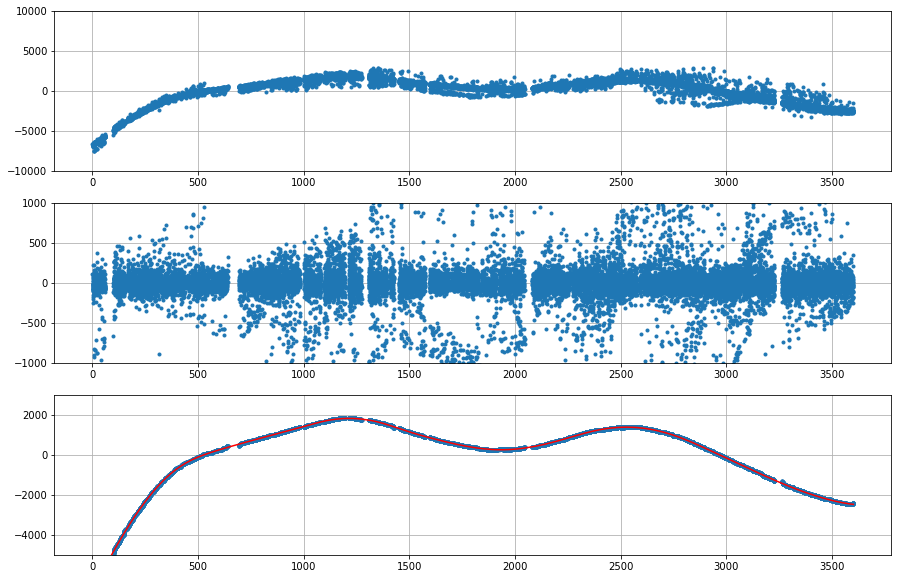

In [46]:
sss.check_result(ylim3=[-5e3, 3e3])

In [47]:
sss.save()

In [49]:
## Check that time gaps for station 679 were saved properly

with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)
    
st_params['679']['gaps']

[[58.879126588133055, 100.82349415572222],
 [639.1646276306828, 695.6625732189237],
 [1272.6521451943147, 1308.3761280158599],
 [2044.6645836061382, 2082.201581220409],
 [3224.468889958221, 3264.7659329767134]]

In [50]:
# Reduce the number of points per pair to 700

sss = another_run(700, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  8%|▊         | 5/59 [00:35<06:20,  7.04s/it]

Bad station: 625: error=39.97m
Good station 23: error=23.49m, distance=9.953m
Good station 23: error=23.48m, distance=0.5343m


 10%|█         | 6/59 [01:48<19:17, 21.84s/it]

Good station 23: error=23.7m, distance=1.893m
Good station 173: error=31.97m, distance=27.65m
Good station 173: error=31.78m, distance=5.101m


 20%|██        | 12/59 [04:26<19:22, 24.73s/it]

Good station 173: error=31.87m, distance=0.0m
Good station 511: error=26.88m, distance=22.81m
Good station 511: error=26.66m, distance=1.313m


 22%|██▏       | 13/59 [05:44<24:28, 31.93s/it]

Good station 511: error=26.75m, distance=0.3736m
Good station 223: error=32.87m, distance=9.059m
Good station 223: error=32.88m, distance=1.858m


 32%|███▏      | 19/59 [06:46<13:34, 20.35s/it]

Good station 223: error=32.9m, distance=2.144m
Good station 166: error=33.33m, distance=12.05m
Good station 166: error=33.34m, distance=2.73m


 36%|███▌      | 21/59 [07:56<14:47, 23.36s/it]

Good station 166: error=33.23m, distance=0.9467m
Good station 83: error=34.01m, distance=18.47m
Good station 83: error=33.83m, distance=2.495m


 41%|████      | 24/59 [09:16<14:12, 24.36s/it]

Good station 83: error=33.89m, distance=0.6386m
Good station 701: error=20.97m, distance=19.86m
Good station 701: error=20.96m, distance=0.787m


 46%|████▌     | 27/59 [10:30<13:01, 24.44s/it]

Good station 701: error=21.1m, distance=3.662m


 51%|█████     | 30/59 [11:22<10:47, 22.33s/it]

Bad station: 375: error=37.72m


 53%|█████▎    | 31/59 [11:56<11:03, 23.70s/it]

Bad station: 665: error=35.51m
Good station 326: error=16.98m, distance=5.299m
Good station 326: error=16.95m, distance=0.3454m


 54%|█████▍    | 32/59 [13:00<13:25, 29.82s/it]

Good station 326: error=16.94m, distance=0.84m
Good station 132: error=25.89m, distance=27.63m
Good station 132: error=25.8m, distance=1.136m


 66%|██████▌   | 39/59 [14:03<05:46, 17.34s/it]

Good station 132: error=25.9m, distance=2.583m
Good station 306: error=31.55m, distance=36.71m
Good station 306: error=31.5m, distance=0.9969m


 71%|███████   | 42/59 [15:13<05:21, 18.90s/it]

Good station 306: error=31.63m, distance=1.651m
Good station 618: error=22.72m, distance=8.142m
Good station 618: error=22.72m, distance=0.77m


 75%|███████▍  | 44/59 [18:30<08:47, 35.15s/it]

Good station 618: error=22.69m, distance=1.409m
Good station 399: error=21.48m, distance=32.46m
Good station 399: error=21.49m, distance=0.2576m


100%|██████████| 59/59 [19:45<00:00, 20.09s/it]

Good station 399: error=21.47m, distance=0.3124m
Number of synchronized stations= 104


In [51]:
# keep these stations for the future 
future += [625, 375, 665]

In [52]:
sss = another_run(700, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/49 [00:00<?, ?it/s]

Good station 170: error=22.95m, distance=16.6m
Good station 170: error=23.01m, distance=1.802m


 12%|█▏        | 6/49 [00:51<06:12,  8.65s/it]

Good station 170: error=23.0m, distance=0.4617m
Good station 345: error=27.1m, distance=9.901m
Good station 345: error=27.05m, distance=1.2m


 18%|█▊        | 9/49 [02:21<11:41, 17.54s/it]

Good station 345: error=26.94m, distance=1.79m
Good station 142: error=18.05m, distance=21.83m
Good station 142: error=18.09m, distance=0.2518m


 24%|██▍       | 12/49 [03:43<13:00, 21.10s/it]

Good station 142: error=18.11m, distance=1.045m
Good station 386: error=22.5m, distance=10.78m
Good station 386: error=22.44m, distance=0.8023m


 73%|███████▎  | 36/49 [04:42<01:18,  6.01s/it]

Good station 386: error=22.53m, distance=1.773m
Good station 658: error=29.07m, distance=12.75m
Good station 658: error=29.02m, distance=0.6513m


100%|██████████| 49/49 [07:06<00:00,  8.70s/it]

Good station 658: error=29.07m, distance=0.5274m
Number of synchronized stations= 109


In [53]:
sss = another_run(700, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/48 [00:00<?, ?it/s]

Good station 479: error=20.73m, distance=1.098e+03m
Good station 479: error=20.75m, distance=1.515m


 10%|█         | 5/48 [01:18<11:18, 15.79s/it]

Good station 479: error=20.77m, distance=1.076m
Good station 92: error=31.52m, distance=28.44m
Good station 92: error=31.58m, distance=0.1056m


 17%|█▋        | 8/48 [02:12<11:07, 16.68s/it]

Good station 92: error=31.47m, distance=0.6898m
Good station 288: error=17.27m, distance=19.89m
Good station 288: error=17.25m, distance=0.9936m


 29%|██▉       | 14/48 [03:20<07:45, 13.68s/it]

Good station 288: error=17.28m, distance=0.375m
Good station 405: error=28.95m, distance=14.32m
Good station 405: error=29.02m, distance=2.254m


 40%|███▉      | 19/48 [04:26<06:32, 13.52s/it]

Good station 405: error=28.91m, distance=0.2302m
Good station 594: error=19.02m, distance=11.62m
Good station 594: error=19.06m, distance=1.552m


 60%|██████    | 29/48 [05:35<03:08,  9.94s/it]

Good station 594: error=19.07m, distance=0.8855m
Good station 640: error=20.55m, distance=10.31m
Good station 640: error=20.68m, distance=1.324m


100%|██████████| 48/48 [06:51<00:00,  8.57s/it]

Good station 640: error=20.72m, distance=0.9299m
Number of synchronized stations= 115


In [54]:
sss = another_run(700, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/42 [00:00<?, ?it/s]

Good station 583: error=28.84m, distance=11.45m
Good station 583: error=28.98m, distance=0.998m


 17%|█▋        | 7/42 [03:32<17:43, 30.38s/it]

Good station 583: error=28.81m, distance=1.643m
Good station 644: error=33.33m, distance=8.536m
Good station 644: error=33.34m, distance=1.501m


 26%|██▌       | 11/42 [04:34<12:13, 23.68s/it]

Good station 644: error=33.28m, distance=1.492m
Good station 704: error=21.93m, distance=22.7m
Good station 704: error=21.76m, distance=1.518m


 31%|███       | 13/42 [05:30<11:57, 24.73s/it]

Good station 704: error=22.2m, distance=0.5066m
Good station 198: error=27.91m, distance=8.371m
Good station 198: error=28.01m, distance=0.2665m


 48%|████▊     | 20/42 [06:09<05:13, 14.25s/it]

Good station 198: error=28.04m, distance=0.2797m
Good station 709: error=17.05m, distance=8.925m
Good station 709: error=17.07m, distance=0.3394m


 69%|██████▉   | 29/42 [09:24<03:53, 17.96s/it]

Good station 709: error=16.87m, distance=0.01776m


100%|██████████| 42/42 [09:43<00:00, 13.90s/it]

Station 596: Large time gap of 279.9, error 18.46m, skip
Number of synchronized stations= 120


### Station 596

In [59]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(596)

sss.prepare_data(tracks, st, 596, 20000)
sss.optimize()

Median error: 18.48m using s=3e-12
Max time gap: 279.3s
Delta distance: 8.307m


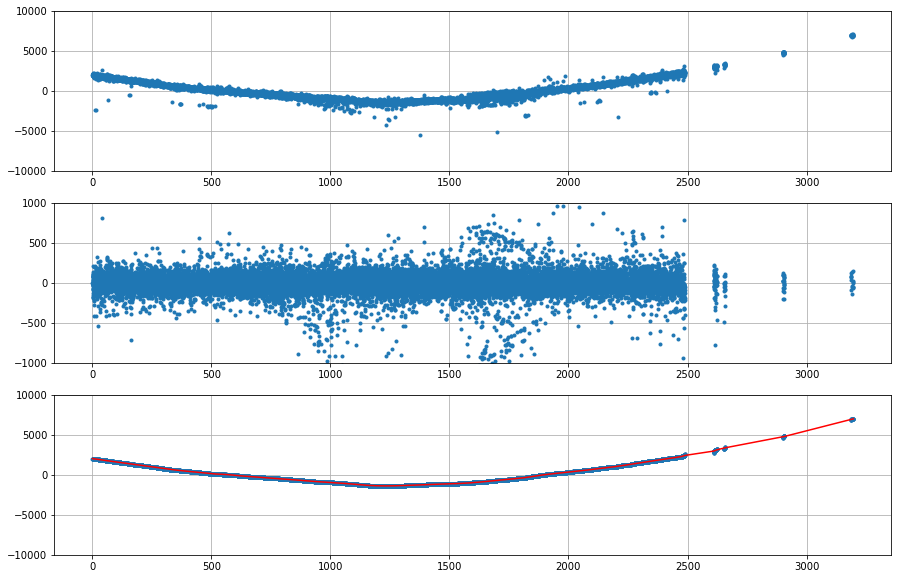

In [60]:
sss.check_result(ylim3=[-1e4, 1e4])

In [61]:
sss.save()

In [62]:
sss = another_run(600, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/45 [00:00<?, ?it/s]

Good station 529: error=31.38m, distance=30.55m
Good station 529: error=31.45m, distance=0.7925m


 13%|█▎        | 6/45 [00:45<04:54,  7.55s/it]

Good station 529: error=31.39m, distance=0.1234m
Good station 507: error=29.17m, distance=24.47m
Good station 507: error=29.15m, distance=1.885m


 16%|█▌        | 7/45 [01:38<10:18, 16.27s/it]

Good station 507: error=29.3m, distance=1.509m


 18%|█▊        | 8/45 [01:56<10:15, 16.63s/it]

Station 512: Large time gap of 65.87, error 27.09m, skip
Good station 611: error=24.84m, distance=9.02m
Good station 611: error=24.51m, distance=1.062m


 20%|██        | 9/45 [03:00<16:39, 27.77s/it]

Good station 611: error=24.3m, distance=0.5285m


 24%|██▍       | 11/45 [03:21<11:51, 20.92s/it]

Bad station: 520: error=44.53m
Good station 196: error=22.86m, distance=1.871e+03m
Good station 196: error=22.9m, distance=0.7279m


 29%|██▉       | 13/45 [05:00<16:40, 31.27s/it]

Good station 196: error=22.84m, distance=1.391m


 36%|███▌      | 16/45 [05:35<11:00, 22.77s/it]

Bad station: 669: error=45.48m
Good station 193: error=23.88m, distance=6.432m
Good station 193: error=23.93m, distance=1.802m


 38%|███▊      | 17/45 [06:17<12:07, 25.97s/it]

Good station 193: error=23.82m, distance=1.527m
Good station 411: error=27.28m, distance=27.16m
Good station 411: error=27.21m, distance=0.1869m


 42%|████▏     | 19/45 [07:19<12:01, 27.76s/it]

Good station 411: error=27.19m, distance=3.217m
Good station 687: error=27.59m, distance=88.22m
Good station 687: error=27.53m, distance=0.3098m


 60%|██████    | 27/45 [08:09<04:06, 13.67s/it]

Good station 687: error=27.61m, distance=1.253m
Good station 664: error=21.69m, distance=19.15m
Good station 664: error=21.69m, distance=2.297m


 67%|██████▋   | 30/45 [09:16<03:58, 15.87s/it]

Good station 664: error=21.76m, distance=1.75m
Good station 518: error=20.75m, distance=25.88m
Good station 518: error=20.57m, distance=0.08097m


 73%|███████▎  | 33/45 [10:09<03:16, 16.36s/it]

Good station 518: error=20.59m, distance=1.23m
Good station 463: error=21.61m, distance=28.98m
Good station 463: error=21.53m, distance=0.2186m


100%|██████████| 45/45 [10:58<00:00, 14.64s/it]

Good station 463: error=21.55m, distance=0.277m
Number of synchronized stations= 131


In [63]:
future += [520, 669]

### Station 512

In [68]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(512)

sss.prepare_data(tracks, st, 512, 20000)
sss.optimize()

Median error: 27.12m using s=2.5e-12
Max time gap: 65.87s
Delta distance: 4.592m


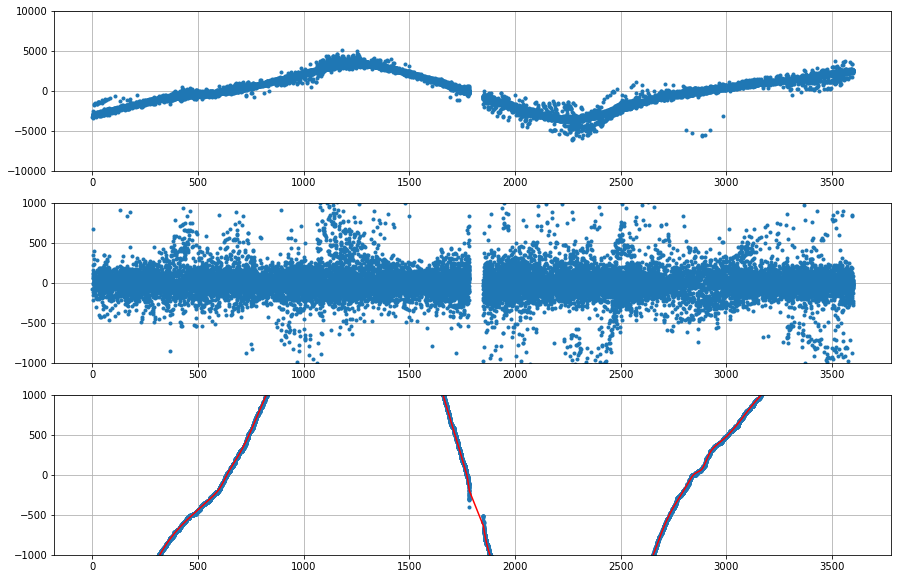

In [69]:
sss.check_result()

In [70]:
sss.save()

In [71]:
sss = another_run(600, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/32 [00:00<?, ?it/s]

Good station 527: error=31.89m, distance=34.78m
Good station 527: error=31.92m, distance=1.55m


100%|██████████| 32/32 [01:01<00:00,  1.91s/it]

Good station 527: error=31.88m, distance=0.7338m
Number of synchronized stations= 133


In [72]:
sss = another_run(500, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 10%|▉         | 4/42 [00:20<03:12,  5.06s/it]

Bad station: 256: error=40.19m
Good station 203: error=30.28m, distance=18.24m
Good station 203: error=30.16m, distance=3.052m


 14%|█▍        | 6/42 [02:02<14:31, 24.22s/it]

Good station 203: error=30.37m, distance=0.7947m
Good station 674: error=22.62m, distance=1.108e+04m
Good station 674: error=22.49m, distance=2.647m


 17%|█▋        | 7/42 [03:42<24:20, 41.72s/it]

Good station 674: error=22.55m, distance=3.326m
Good station 315: error=25.25m, distance=14.22m
Good station 315: error=25.51m, distance=1.908m


 19%|█▉        | 8/42 [05:17<31:02, 54.78s/it]

Good station 315: error=25.41m, distance=2.198m
Good station 155: error=21.31m, distance=16.1m
Good station 155: error=21.25m, distance=1.759m


 36%|███▌      | 15/42 [06:21<10:02, 22.30s/it]

Good station 155: error=21.32m, distance=0.3741m
Good station 620: error=28.09m, distance=11.71m
Good station 620: error=28.39m, distance=0.5418m


 40%|████      | 17/42 [07:12<09:36, 23.07s/it]

Good station 620: error=28.2m, distance=1.309m
Good station 350: error=27.39m, distance=6.19m
Good station 350: error=27.42m, distance=1.359m


 43%|████▎     | 18/42 [08:08<11:02, 27.60s/it]

Good station 350: error=27.45m, distance=0.4818m


 55%|█████▍    | 23/42 [08:26<04:57, 15.67s/it]

Bad station: 162: error=35.22m
Good station 240: error=16.0m, distance=18.84m
Good station 240: error=16.01m, distance=0.3392m


 67%|██████▋   | 28/42 [09:47<03:42, 15.90s/it]

Good station 240: error=16.02m, distance=0.5921m
Good station 372: error=25.23m, distance=47.56m
Good station 372: error=25.18m, distance=1.187m


 79%|███████▊  | 33/42 [10:54<02:14, 14.96s/it]

Good station 372: error=25.25m, distance=0.1098m
Good station 369: error=24.01m, distance=13.19m
Good station 369: error=23.8m, distance=0.1576m


 83%|████████▎ | 35/42 [11:43<01:56, 16.57s/it]

Good station 369: error=23.87m, distance=1.793m


100%|██████████| 42/42 [12:06<00:00, 17.30s/it]

Bad station: 689: error=43.76m
Number of synchronized stations= 142


In [73]:
future += [256, 162, 689]

In [74]:
sss = another_run(500, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/32 [00:00<?, ?it/s]

Good station 542: error=26.87m, distance=13.96m
Good station 542: error=27.0m, distance=0.2718m


 12%|█▎        | 4/32 [00:47<05:31, 11.84s/it]

Good station 542: error=27.03m, distance=0.356m
Good station 659: error=28.18m, distance=2.586m
Good station 659: error=28.13m, distance=1.286m


100%|██████████| 32/32 [56:23<00:00, 105.73s/it] 

Good station 659: error=28.07m, distance=1.009m
Number of synchronized stations= 144


In [75]:
sss = another_run(500, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 33%|███▎      | 10/30 [00:23<00:46,  2.35s/it]

Bad station: 599: error=37.67m
Good station 522: error=24.4m, distance=10.05m
Good station 522: error=24.48m, distance=1.365m


100%|██████████| 30/30 [01:21<00:00,  2.72s/it]

Good station 522: error=24.37m, distance=1.574m
Number of synchronized stations= 145


In [76]:
future += [599]

In [79]:
sss = another_run(400, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/42 [00:00<?, ?it/s]

Good station 26: error=32.01m, distance=1.707e+05m
Good station 26: error=31.96m, distance=0.3684m


 14%|█▍        | 6/42 [02:13<13:20, 22.24s/it]

Good station 26: error=31.89m, distance=0.6999m


 17%|█▋        | 7/42 [02:37<13:07, 22.49s/it]

Bad station: 55: error=37.22m


 29%|██▊       | 12/42 [03:00<06:06, 12.23s/it]

Bad station: 290: error=46.55m
Good station 558: error=31.04m, distance=33.48m
Good station 558: error=30.93m, distance=1.633m


 31%|███       | 13/42 [04:38<11:44, 24.30s/it]

Good station 558: error=30.96m, distance=0.4989m
Good station 495: error=20.56m, distance=71.04m
Good station 495: error=20.57m, distance=0.07233m


 36%|███▌      | 15/42 [05:27<11:00, 24.48s/it]

Good station 495: error=20.65m, distance=1.731m
Good station 610: error=26.65m, distance=87.37m
Good station 610: error=26.61m, distance=0.496m


 45%|████▌     | 19/42 [06:32<07:57, 20.76s/it]

Good station 610: error=26.58m, distance=1.685m
Good station 175: error=32.4m, distance=58.96m
Good station 175: error=32.43m, distance=0.3669m


 48%|████▊     | 20/42 [07:36<09:48, 26.76s/it]

Good station 175: error=32.28m, distance=3.434m
Good station 307: error=28.95m, distance=13.23m
Good station 307: error=28.77m, distance=0.2978m


 62%|██████▏   | 26/42 [08:36<04:41, 17.59s/it]

Good station 307: error=28.78m, distance=0.913m
Good station 321: error=34.39m, distance=48.48m
Good station 321: error=34.45m, distance=1.155m


 67%|██████▋   | 28/42 [09:25<04:26, 19.06s/it]

Good station 321: error=34.3m, distance=2.541m
Good station 304: error=33.25m, distance=11.32m
Good station 304: error=33.38m, distance=1.431m


 69%|██████▉   | 29/42 [11:26<06:56, 32.04s/it]

Good station 304: error=33.31m, distance=1.193m
Good station 218: error=18.88m, distance=9.559m
Good station 218: error=18.89m, distance=0.03196m


 76%|███████▌  | 32/42 [12:14<04:23, 26.36s/it]

Good station 218: error=18.87m, distance=0.6885m
Good station 114: error=22.36m, distance=21.01m
Good station 114: error=22.43m, distance=1.562m


 79%|███████▊  | 33/42 [12:56<04:18, 28.68s/it]

Good station 114: error=22.49m, distance=2.464m


100%|██████████| 42/42 [12:57<00:00, 18.52s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 155


In [80]:
future += [55, 290]

In [81]:
sss = another_run(400, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/39 [00:00<?, ?it/s]

Good station 201: error=24.57m, distance=17.09m
Good station 201: error=24.62m, distance=1.131m


 13%|█▎        | 5/39 [00:49<05:39,  9.97s/it]

Good station 201: error=24.67m, distance=1.935m
Good station 352: error=33.33m, distance=25.66m
Good station 352: error=33.38m, distance=1.646m


 15%|█▌        | 6/39 [01:45<11:03, 20.11s/it]

Good station 352: error=33.35m, distance=0.9228m
Good station 616: error=24.89m, distance=89.42m
Good station 616: error=24.93m, distance=1.06m


 28%|██▊       | 11/39 [04:13<12:06, 25.94s/it]

Good station 616: error=24.83m, distance=0.2056m


 79%|███████▉  | 31/39 [04:14<00:46,  5.80s/it]

Station 368 has less than 20000 points, skip


100%|██████████| 39/39 [04:16<00:00,  6.57s/it]

Station 673 has less than 20000 points, skip
Number of synchronized stations= 158


In [82]:
sss = another_run(400, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/39 [00:00<?, ?it/s]

Good station 469: error=33.45m, distance=6.421m
Good station 469: error=33.38m, distance=0.6401m


 15%|█▌        | 6/39 [00:51<04:45,  8.64s/it]

Good station 469: error=33.38m, distance=0.4564m
Good station 543: error=31.59m, distance=9.53m
Good station 543: error=31.58m, distance=0.9741m


 18%|█▊        | 7/39 [01:35<08:11, 15.37s/it]

Good station 543: error=31.52m, distance=0.6859m


 21%|██        | 8/39 [01:52<08:09, 15.79s/it]

Bad station: 367: error=39.62m
Good station 215: error=22.82m, distance=317.7m
Good station 215: error=22.84m, distance=0.2088m


 23%|██▎       | 9/39 [02:54<13:17, 26.59s/it]

Good station 215: error=22.83m, distance=0.2366m


 28%|██▊       | 11/39 [03:17<09:32, 20.45s/it]

Bad station: 694: error=35.18m


 36%|███▌      | 14/39 [03:33<05:37, 13.51s/it]

Bad station: 673: error=40.99m


100%|██████████| 39/39 [03:34<00:00,  5.50s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 161


In [83]:
future += [367, 694, 673]

In [84]:
sss = another_run(400, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/33 [00:00<?, ?it/s]

Good station 236: error=28.39m, distance=11.62m
Good station 236: error=28.3m, distance=1.089m


 15%|█▌        | 5/33 [01:06<06:13, 13.33s/it]

Good station 236: error=28.42m, distance=0.9164m


 18%|█▊        | 6/33 [01:23<06:21, 14.13s/it]

Station 667: Large time gap of 50.02, error 20.02m, skip
Good station 176: error=27.96m, distance=51.57m
Good station 176: error=28.04m, distance=1.15m


 27%|██▋       | 9/33 [02:18<06:29, 16.21s/it]

Good station 176: error=28.14m, distance=0.8858m
Good station 624: error=26.89m, distance=786.7m
Good station 624: error=26.92m, distance=1.917m


 48%|████▊     | 16/33 [03:29<03:31, 12.42s/it]

Good station 624: error=26.94m, distance=1.203m


 79%|███████▉  | 26/33 [03:30<00:38,  5.57s/it]

Station 502 has less than 20000 points, skip


100%|██████████| 33/33 [03:31<00:00,  6.42s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 164


### Station 667

In [85]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(667)

sss.prepare_data(tracks, st, 667, 20000)
sss.optimize()

Median error: 19.97m using s=2e-12
Max time gap: 50.02s
Delta distance: 43.6m


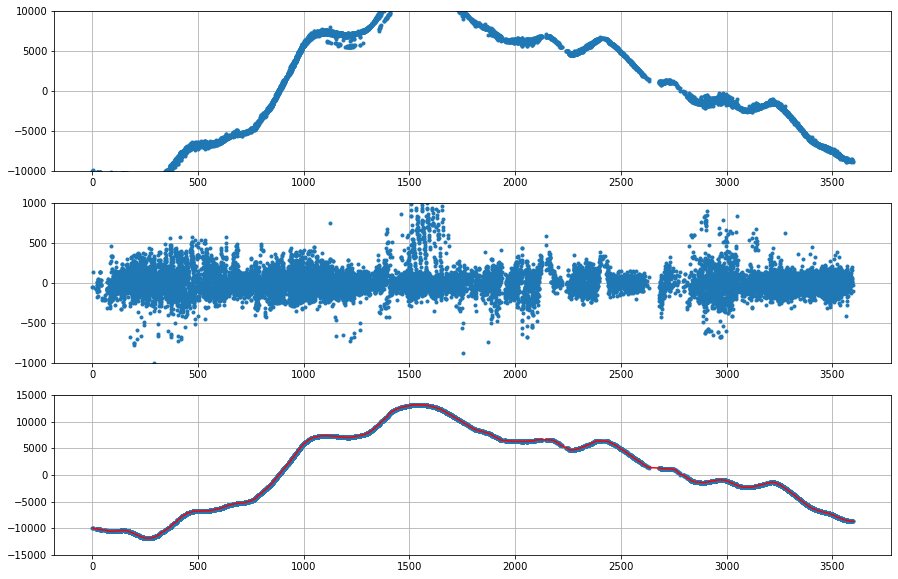

In [86]:
sss.check_result(ylim3=[-1.5e4, 1.5e4])

In [87]:
sss.save()

In [88]:
sss = another_run(400, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/29 [00:00<?, ?it/s]

Good station 502: error=27.38m, distance=68.81m
Good station 502: error=27.28m, distance=1.487m


 17%|█▋        | 5/29 [01:04<05:10, 12.94s/it]

Good station 502: error=27.37m, distance=2.345m


100%|██████████| 29/29 [01:05<00:00,  2.27s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 166


In [89]:
sss = another_run(300, bad + last_order, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/41 [00:00<?, ?it/s]

Good station 578: error=33.37m, distance=63.17m
Good station 578: error=32.96m, distance=0.2953m


 15%|█▍        | 6/41 [01:12<07:04, 12.12s/it]

Good station 578: error=33.09m, distance=0.5164m
Good station 379: error=33.98m, distance=7.986m
Good station 379: error=34.15m, distance=0.8639m


 17%|█▋        | 7/41 [05:03<30:44, 54.25s/it]

Good station 379: error=34.02m, distance=1.262m
Good station 498: error=24.48m, distance=1.252e+04m
Good station 498: error=24.42m, distance=2.083m


 20%|█▉        | 8/41 [06:31<33:45, 61.38s/it]

Good station 498: error=24.5m, distance=0.4352m


 22%|██▏       | 9/41 [06:33<25:17, 47.43s/it]

Station 570 has less than 20000 points, skip


 29%|██▉       | 12/41 [06:35<11:33, 23.92s/it]

Station 445 has less than 20000 points, skip


 32%|███▏      | 13/41 [07:24<13:28, 28.87s/it]

Station 681: Large time gap of 182.9, error 27.99m, skip
Good station 192: error=20.54m, distance=21.62m
Good station 192: error=20.52m, distance=0.2524m


 34%|███▍      | 14/41 [08:33<16:50, 37.43s/it]

Good station 192: error=20.53m, distance=0.9585m
Good station 444: error=24.13m, distance=17.02m
Good station 444: error=24.12m, distance=1.75m


 39%|███▉      | 16/41 [09:26<13:51, 33.25s/it]

Good station 444: error=24.13m, distance=0.5494m
Good station 614: error=23.98m, distance=14.77m
Good station 614: error=24.22m, distance=0.1581m


 41%|████▏     | 17/41 [10:19<15:01, 37.57s/it]

Good station 614: error=24.18m, distance=0.367m
Good station 584: error=22.35m, distance=7.732m
Good station 584: error=22.41m, distance=0.1309m


 44%|████▍     | 18/41 [11:35<17:50, 46.55s/it]

Good station 584: error=22.36m, distance=1.052m
Good station 360: error=31.88m, distance=27.9m
Good station 360: error=32.04m, distance=4.181m


 46%|████▋     | 19/41 [12:18<16:46, 45.76s/it]

Good station 360: error=31.89m, distance=0.5053m


 56%|█████▌    | 23/41 [12:32<06:14, 20.81s/it]

Station 368: Large time gap of 367.4, error 22.99m, skip


 73%|███████▎  | 30/41 [12:33<01:33,  8.46s/it]

Station 165 has less than 20000 points, skip


100%|██████████| 41/41 [12:50<00:00, 18.80s/it]

Station 675: Large time gap of 64.64, error 24.18m, skip
Number of synchronized stations= 174


### Station 681

In [92]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(681)

sss.prepare_data(tracks, st, 681, 20000)
sss.optimize()

Median error: 27.85m using s=1e-11
Max time gap: 182.9s
Delta distance: 12.41m


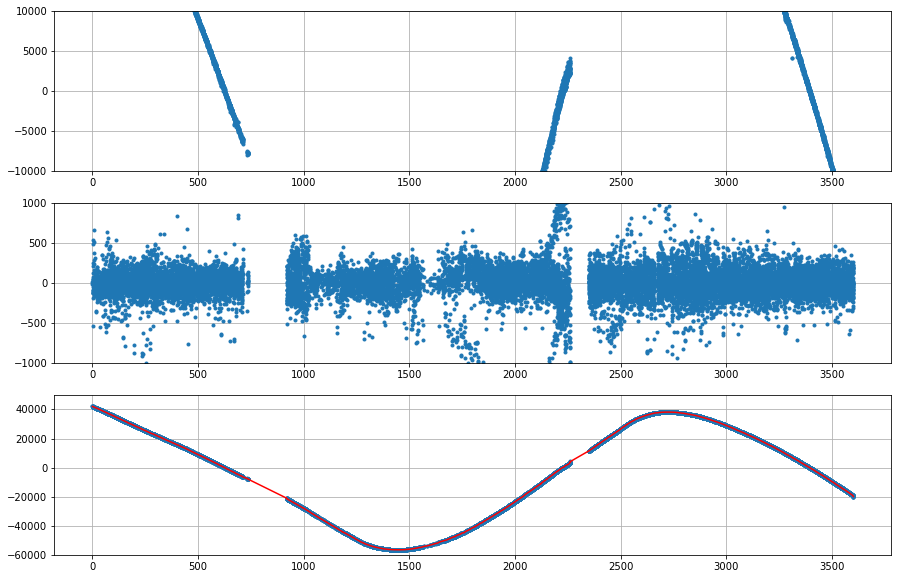

In [93]:
sss.check_result(ylim3=[-6e4, 5e4])

In [94]:
sss.save()

### Station 368

In [97]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(368)

sss.prepare_data(tracks, st, 368, 20000)
sss.optimize()

Median error: 23.03m using s=2e-12
Max time gap: 367.4s
Delta distance: 2.21m


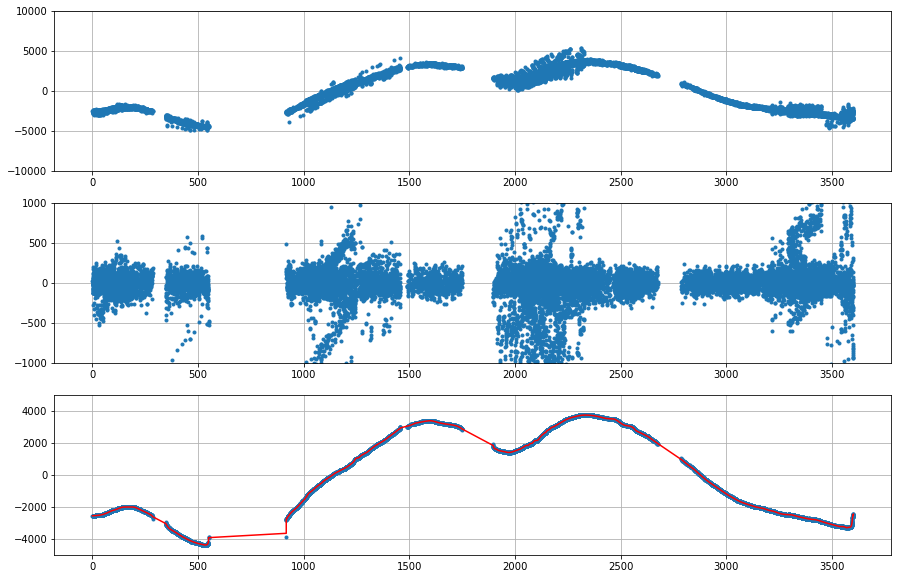

In [98]:
sss.check_result(ylim3=[-5e3, 5e3])

In [99]:
# Add this station later
future += [368]

### Station 675

In [104]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(675)

sss.prepare_data(tracks, st, 675, 20000)
sss.optimize()

Median error: 24.17m using s=2e-12
Max time gap: 64.64s
Delta distance: 15.9m


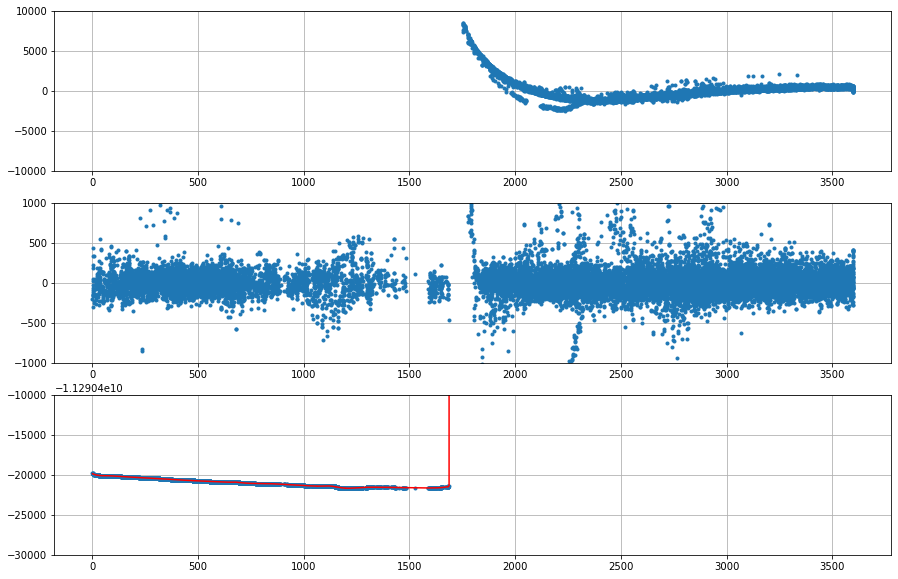

In [105]:
sss.check_result(ylim3=[-1.129043e10, -1.129041e10])

In [106]:
sss.save()

In [108]:
# Reduce number of sampling points to 15,000

sss = another_run(300, bad + last_order, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 20%|██        | 6/30 [00:14<00:59,  2.47s/it]

Bad station: 570: error=41.67m
Good station 445: error=30.52m, distance=2.115e+03m
Good station 445: error=30.4m, distance=0.71m


 30%|███       | 9/30 [01:01<02:46,  7.92s/it]

Good station 445: error=30.36m, distance=0.2758m


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]

Station 165 has less than 15000 points, skip
Number of synchronized stations= 177


In [109]:
future += [570]

In [110]:
sss = another_run(200, bad + last_order, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/36 [00:00<?, ?it/s]

Good station 576: error=25.65m, distance=21.76m
Good station 576: error=25.69m, distance=2.486m


 19%|█▉        | 7/36 [01:58<08:10, 16.91s/it]

Good station 576: error=25.59m, distance=0.3548m


 28%|██▊       | 10/36 [01:59<04:36, 10.62s/it]

Station 597 has less than 15000 points, skip


 31%|███       | 11/36 [02:10<04:26, 10.66s/it]

Station 441: Large time gap of 76.5, error 24.11m, skip


 33%|███▎      | 12/36 [02:28<04:50, 12.10s/it]

Bad station: 442: error=38.09m


 36%|███▌      | 13/36 [02:30<03:46,  9.84s/it]

Station 698 has less than 15000 points, skip
Good station 489: error=27.48m, distance=1.234m
Good station 489: error=27.35m, distance=2.385m


 47%|████▋     | 17/36 [03:42<04:32, 14.33s/it]

Good station 489: error=27.44m, distance=0.758m
Good station 492: error=29.58m, distance=93.81m
Good station 492: error=29.14m, distance=1.509m


 50%|█████     | 18/36 [06:04<10:28, 34.90s/it]

Good station 492: error=29.29m, distance=0.1764m
Good station 696: error=28.43m, distance=6.241m
Good station 696: error=28.36m, distance=0.442m


 58%|█████▊    | 21/36 [06:49<06:42, 26.80s/it]

Good station 696: error=28.43m, distance=0.2768m


 69%|██████▉   | 25/36 [06:50<02:46, 15.13s/it]

Station 711 has less than 15000 points, skip


 78%|███████▊  | 28/36 [06:50<01:22, 10.36s/it]

Station 165 has less than 15000 points, skip


 83%|████████▎ | 30/36 [07:00<00:54,  9.06s/it]

Station 253: Large time gap of 59.13, error 32.49m, skip


100%|██████████| 36/36 [07:01<00:00, 11.70s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 181


In [111]:
future += [442]

### Station 441

In [116]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(441)

sss.prepare_data(tracks, st, 441, 20000)
sss.optimize()

Median error: 23.89m using s=2.5e-12
Max time gap: 76.5s
Delta distance: 5.958m


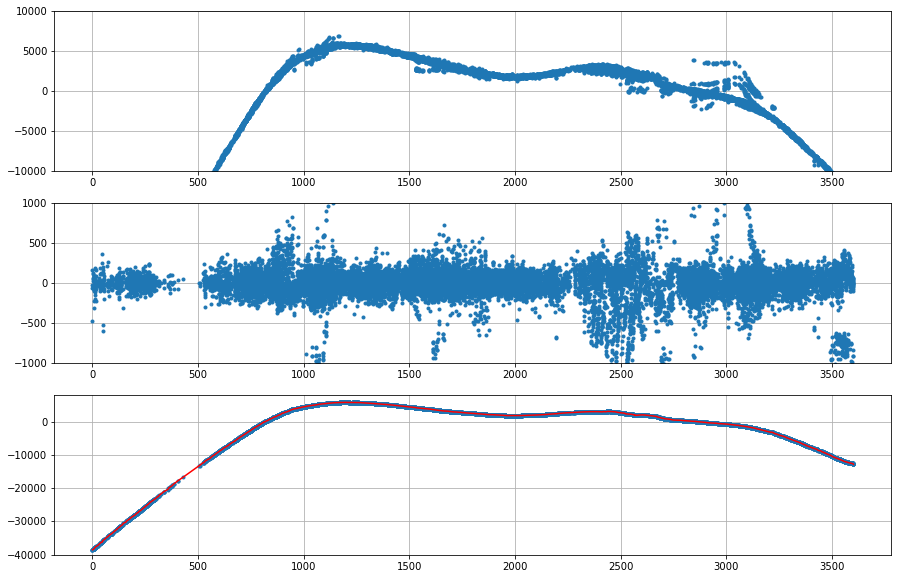

In [117]:
sss.check_result(ylim3=[-4e4, 8e3])

In [118]:
sss.save()

### Station 253

In [119]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(253)

sss.prepare_data(tracks, st, 253, 20000)
sss.optimize()

Median error: 32.33m using s=2e-12
Max time gap: 59.13s
Delta distance: 10.12m


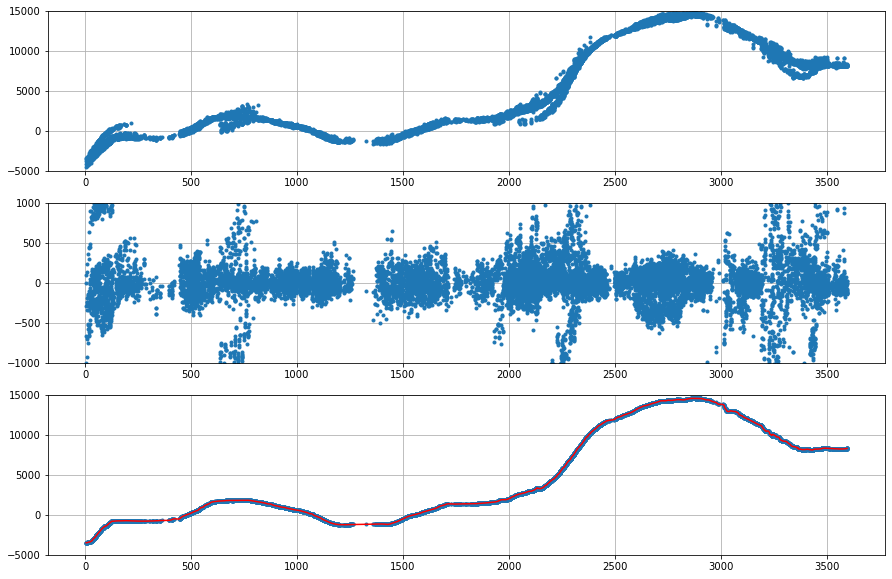

In [120]:
sss.check_result(ylim1=[-5e3, 1.5e4], ylim3=[-5e3, 1.5e4])

In [121]:
sss.save()

In [124]:
# Try to review future stations now

sss = another_run(200, bad + last_order, [], max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 15%|█▌        | 7/46 [01:43<09:38, 14.83s/it]

Bad station: 625: error=39.11m


 17%|█▋        | 8/46 [02:07<10:19, 16.30s/it]

Bad station: 520: error=36.18m
Good station 55: error=24.1m, distance=21.39m
Good station 55: error=24.31m, distance=2.505m


 20%|█▉        | 9/46 [04:33<25:41, 41.65s/it]

Good station 55: error=24.32m, distance=2.254m
Good station 694: error=31.79m, distance=79.52m
Good station 694: error=31.92m, distance=0.5349m


 22%|██▏       | 10/46 [05:53<29:59, 50.00s/it]

Good station 694: error=32.0m, distance=2.596m


 24%|██▍       | 11/46 [06:14<25:07, 43.08s/it]

Bad station: 673: error=41.11m


 26%|██▌       | 12/46 [06:38<21:37, 38.16s/it]

Bad station: 367: error=42.54m
Good station 256: error=31.81m, distance=13.56m
Good station 256: error=31.71m, distance=0.4972m


 28%|██▊       | 13/46 [08:35<32:36, 59.27s/it]

Good station 256: error=31.81m, distance=0.2192m
Good station 599: error=30.56m, distance=19.57m
Good station 599: error=30.56m, distance=1.663m


 30%|███       | 14/46 [09:53<34:19, 64.36s/it]

Good station 599: error=30.57m, distance=1.183m


 33%|███▎      | 15/46 [10:14<26:52, 52.03s/it]

Bad station: 290: error=39.96m


 35%|███▍      | 16/46 [10:29<20:43, 41.44s/it]

Bad station: 570: error=37.06m
Good station 665: error=33.81m, distance=18.95m
Good station 665: error=33.57m, distance=5.85m


 39%|███▉      | 18/46 [13:08<27:20, 58.57s/it]

Good station 665: error=33.84m, distance=3.0m


 41%|████▏     | 19/46 [13:37<23:09, 51.48s/it]

Bad station: 669: error=45.41m


 43%|████▎     | 20/46 [14:11<20:16, 46.81s/it]

Bad station: 375: error=39.19m


 48%|████▊     | 22/46 [14:12<10:53, 27.22s/it]

Station 597 has less than 15000 points, skip


 50%|█████     | 23/46 [14:28<09:24, 24.54s/it]

Bad station: 442: error=38.28m


 52%|█████▏    | 24/46 [14:51<08:55, 24.33s/it]

Bad station: 162: error=37.96m


 54%|█████▍    | 25/46 [14:52<06:22, 18.22s/it]

Station 698 has less than 15000 points, skip


 63%|██████▎   | 29/46 [15:16<03:02, 10.75s/it]

Bad station: 689: error=36.55m


 70%|██████▉   | 32/46 [15:30<01:58,  8.44s/it]

Station 368: Large time gap of 367.4, error 23.27m, skip


 78%|███████▊  | 36/46 [15:31<00:49,  4.90s/it]

Station 711 has less than 15000 points, skip


 85%|████████▍ | 39/46 [15:31<00:24,  3.44s/it]

Station 165 has less than 15000 points, skip


100%|██████████| 46/46 [15:32<00:00, 20.27s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 188


In [125]:
future = [625, 520, 673, 367, 290, 570, 669, 375, 442, 162, 689]

### Station 368

In [134]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(368)

sss.prepare_data(tracks, st, 368, 20000)
sss.optimize()

Median error: 23.15m using s=2e-12
Max time gap: 367.4s
Delta distance: 3.111m


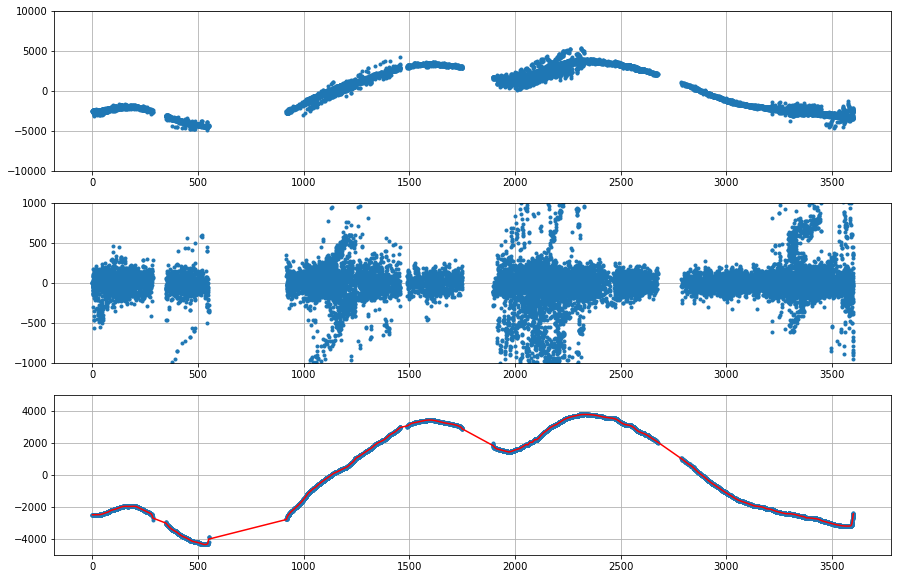

In [135]:
sss.check_result(ylim3=[-5e3, 5e3])

In [136]:
sss.save()

In [137]:
sss = another_run(200, bad + last_order, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/29 [00:00<?, ?it/s]

Good station 413: error=32.75m, distance=15.71m
Good station 413: error=32.69m, distance=0.4232m


 28%|██▊       | 8/29 [00:36<01:36,  4.57s/it]

Good station 413: error=32.69m, distance=0.09506m


 31%|███       | 9/29 [00:37<01:20,  4.04s/it]

Station 597 has less than 15000 points, skip


 34%|███▍      | 10/29 [00:38<01:06,  3.50s/it]

Station 165 has less than 15000 points, skip


 38%|███▊      | 11/29 [00:40<00:55,  3.07s/it]

Station 698 has less than 15000 points, skip


 69%|██████▉   | 20/29 [00:40<00:08,  1.11it/s]

Station 711 has less than 15000 points, skip


100%|██████████| 29/29 [00:41<00:00,  1.42s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 190


In [138]:
sss = another_run(200, bad + last_order, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/29 [00:00<?, ?it/s]

Good station 434: error=23.24m, distance=35.15m
Good station 434: error=23.13m, distance=0.705m


  3%|▎         | 1/29 [00:46<21:52, 46.88s/it]

Good station 434: error=23.11m, distance=0.5402m
Good station 552: error=18.95m, distance=38.67m
Good station 552: error=18.94m, distance=0.1417m


  7%|▋         | 2/29 [01:37<22:02, 48.97s/it]

Good station 552: error=18.97m, distance=0.896m


 31%|███       | 9/29 [01:38<02:24,  7.24s/it]

Station 597 has less than 15000 points, skip


 34%|███▍      | 10/29 [01:39<02:00,  6.32s/it]

Station 165 has less than 15000 points, skip


 38%|███▊      | 11/29 [01:40<01:37,  5.40s/it]

Station 698 has less than 15000 points, skip


 69%|██████▉   | 20/29 [01:40<00:15,  1.70s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 29/29 [01:41<00:00,  3.50s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 192


In [139]:
sss = another_run(200, bad + last_order, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/27 [00:00<?, ?it/s]

Good station 628: error=34.27m, distance=13.77m
Good station 628: error=34.23m, distance=4.19m


  4%|▎         | 1/27 [00:53<23:15, 53.69s/it]

Good station 628: error=34.13m, distance=2.609m
Good station 194: error=21.03m, distance=29.18m
Good station 194: error=20.99m, distance=1.356m


  7%|▋         | 2/27 [01:50<23:15, 55.81s/it]

Good station 194: error=20.99m, distance=1.245m


 19%|█▊        | 5/27 [13:21<1:06:15, 180.69s/it]

Bad station: 591: error=41.6m


 22%|██▏       | 6/27 [13:35<48:25, 138.37s/it]  

Bad station: 535: error=44.45m


 26%|██▌       | 7/27 [13:36<33:55, 101.79s/it]

Station 597 has less than 15000 points, skip


 30%|██▉       | 8/27 [13:38<23:26, 74.01s/it] 

Station 165 has less than 15000 points, skip


 33%|███▎      | 9/27 [13:39<16:01, 53.40s/it]

Station 698 has less than 15000 points, skip


 70%|███████   | 19/27 [13:39<01:25, 10.64s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 27/27 [13:40<00:00, 30.37s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 194


In [ ]:
future += [591, 535]

In [140]:
sss = another_run(200, bad + last_order, [], max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/37 [00:00<?, ?it/s]

Good station 662: error=32.76m, distance=22.6m
Good station 662: error=31.42m, distance=5.129m


  3%|▎         | 1/37 [10:47<6:28:46, 647.95s/it]

Good station 662: error=32.06m, distance=0.3519m


  8%|▊         | 3/37 [12:34<1:57:31, 207.40s/it]

Bad station: 625: error=39.28m


 11%|█         | 4/37 [13:00<1:19:31, 144.58s/it]

Bad station: 520: error=36.5m


 14%|█▎        | 5/37 [13:29<56:42, 106.31s/it]  

Bad station: 673: error=40.77m


 16%|█▌        | 6/37 [13:56<41:54, 81.13s/it] 

Bad station: 367: error=41.98m
Good station 290: error=31.82m, distance=21.85m
Good station 290: error=31.68m, distance=2.421m


 19%|█▉        | 7/37 [14:59<37:38, 75.30s/it]

Good station 290: error=31.72m, distance=1.387m


 22%|██▏       | 8/37 [15:16<27:43, 57.37s/it]

Bad station: 570: error=36.25m


 24%|██▍       | 9/37 [27:56<2:07:15, 272.69s/it]

Bad station: 591: error=41.53m


 27%|██▋       | 10/37 [28:32<1:30:17, 200.67s/it]

Bad station: 669: error=41.17m


 30%|██▉       | 11/37 [29:04<1:04:46, 149.49s/it]

Bad station: 375: error=36.47m


 32%|███▏      | 12/37 [29:20<45:31, 109.26s/it]  

Bad station: 535: error=44.52m


 35%|███▌      | 13/37 [29:21<30:38, 76.62s/it] 

Station 597 has less than 15000 points, skip


 38%|███▊      | 14/37 [29:37<22:21, 58.31s/it]

Bad station: 442: error=38.28m


 41%|████      | 15/37 [29:38<15:03, 41.07s/it]

Station 165 has less than 15000 points, skip


 43%|████▎     | 16/37 [30:02<12:30, 35.76s/it]

Bad station: 162: error=36.27m


 46%|████▌     | 17/37 [30:03<08:26, 25.33s/it]

Station 698 has less than 15000 points, skip


 57%|█████▋    | 21/37 [30:27<03:31, 13.23s/it]

Bad station: 689: error=36.84m
Good station 688: error=22.07m, distance=20.62m
Good station 688: error=21.98m, distance=1.793m


 70%|███████   | 26/37 [31:19<02:08, 11.66s/it]

Good station 688: error=22.04m, distance=0.8953m


 76%|███████▌  | 28/37 [31:19<01:21,  9.01s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 37/37 [31:20<00:00, 50.81s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 197


In [141]:
# Increase median error threshold to 40m and check future stations again

sss = another_run(200, bad + last_order, [], max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/38 [00:00<?, ?it/s]

Good station 625: error=39.35m, distance=3.866m
Good station 625: error=39.29m, distance=1.662m


  5%|▌         | 2/38 [05:55<1:46:38, 177.74s/it]

Good station 625: error=39.25m, distance=1.295m
Good station 520: error=36.44m, distance=28.95m
Good station 520: error=36.68m, distance=4.832m


  8%|▊         | 3/38 [07:23<1:21:53, 140.40s/it]

Good station 520: error=36.41m, distance=1.045m


 11%|█         | 4/38 [07:48<55:10, 97.37s/it]   

Bad station: 673: error=40.99m


 13%|█▎        | 5/38 [08:12<39:26, 71.72s/it]

Bad station: 367: error=42.08m
Good station 570: error=36.51m, distance=78.34m
Good station 570: error=36.04m, distance=8.672m


 16%|█▌        | 6/38 [09:10<35:50, 67.20s/it]

Good station 570: error=36.13m, distance=2.503m
Good station 591: error=35.92m, distance=19.18m
Good station 591: error=35.08m, distance=2.329m


 18%|█▊        | 7/38 [49:27<7:05:09, 822.89s/it]

Good station 591: error=34.07m, distance=1.036m


 26%|██▋       | 10/38 [49:59<2:44:22, 352.24s/it]

Bad station: 669: error=40.39m
Good station 375: error=36.56m, distance=516.7m
Good station 375: error=36.7m, distance=1.819m


 29%|██▉       | 11/38 [51:41<2:14:11, 298.20s/it]

Good station 375: error=36.46m, distance=5.081m


 32%|███▏      | 12/38 [51:56<1:40:11, 231.22s/it]

Bad station: 535: error=44.98m


 34%|███▍      | 13/38 [51:57<1:12:09, 173.19s/it]

Station 597 has less than 15000 points, skip
Good station 442: error=38.44m, distance=44.19m
Good station 442: error=38.36m, distance=1.395m


 37%|███▋      | 14/38 [52:44<55:53, 139.74s/it]  

Good station 442: error=38.2m, distance=1.174m


 39%|███▉      | 15/38 [52:45<38:58, 101.69s/it]

Station 165 has less than 15000 points, skip


 42%|████▏     | 16/38 [53:09<29:16, 79.82s/it] 

Station 162: Large time gap of 34.96, error 37.96m, skip


 45%|████▍     | 17/38 [53:10<20:01, 57.23s/it]

Station 698 has less than 15000 points, skip
Good station 689: error=36.68m, distance=25.92m
Good station 689: error=36.74m, distance=5.296m


 55%|█████▌    | 21/38 [54:39<10:02, 35.42s/it]

Good station 689: error=36.74m, distance=5.888m


 71%|███████   | 27/38 [54:39<02:47, 15.24s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 38/38 [54:40<00:00, 86.32s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 204


### Station 162

In [145]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(162)

sss.prepare_data(tracks, st, 162, 20000)
sss.optimize()

Median error: 36.41m using s=2.5e-12
Max time gap: 30.86s
Delta distance: 61.17m


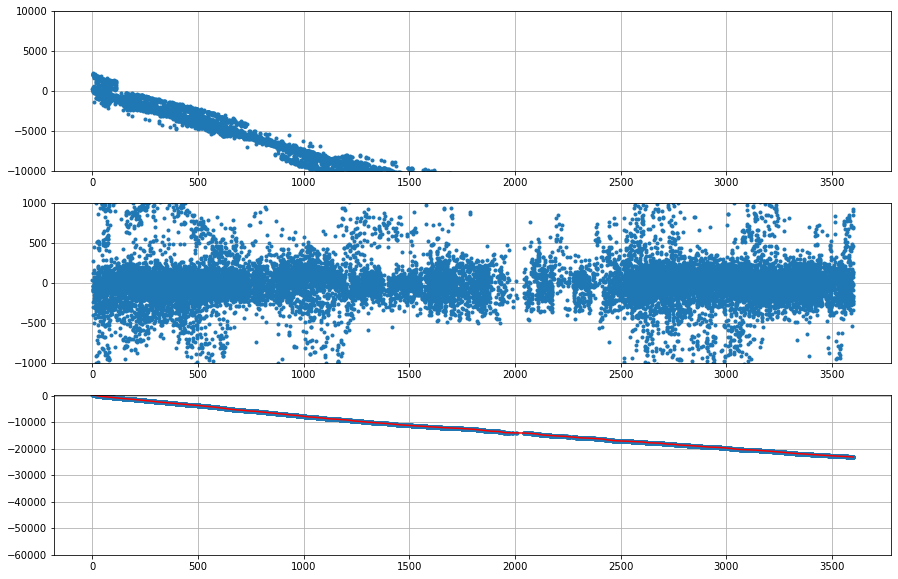

In [146]:
sss.check_result(ylim3=[-6e4, 3e2])

In [147]:
sss.save()

### Station 673

In [155]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(673)

sss.prepare_data(tracks, st, 673, 20000)
sss.optimize()

Median error: 40.82m using s=6e-12
Max time gap: 2.129s
Delta distance: 3.213m


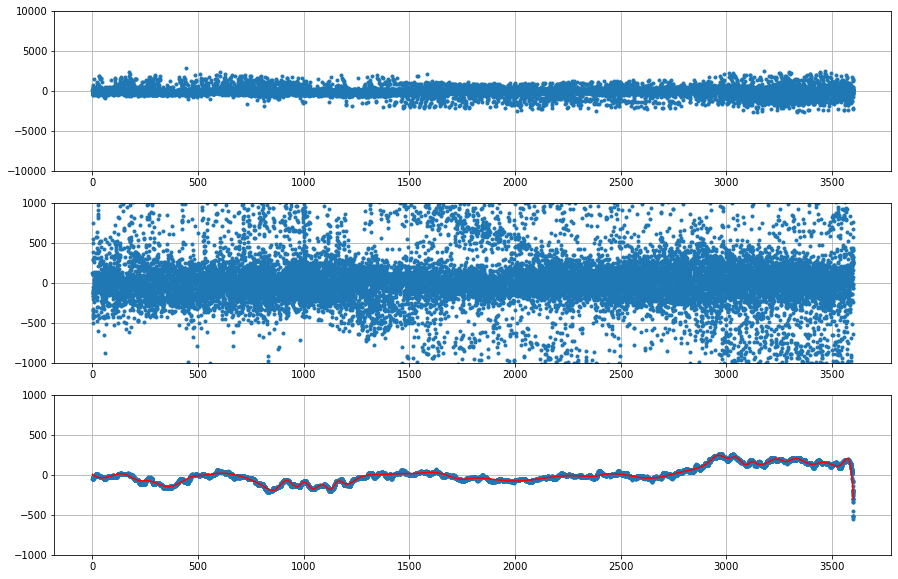

In [156]:
sss.check_result()

In [150]:
sss.save()

### Station 367

In [161]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(367)

sss.prepare_data(tracks, st, 367, 20000)
sss.optimize()

Median error: 42.08m using s=8.5e-12
Max time gap: 2.05s
Delta distance: 19.68m


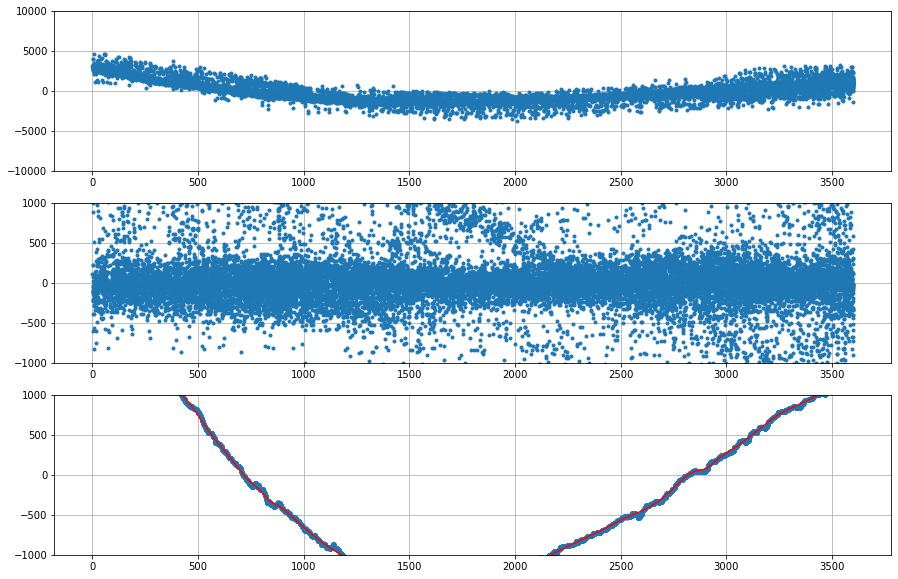

In [162]:
sss.check_result()

In [163]:
sss.save()

### Station 669

In [164]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(669)

sss.prepare_data(tracks, st, 669, 20000)
sss.optimize()

Median error: 40.87m using s=1.35e-11
Max time gap: 2.36s
Delta distance: 28.83m


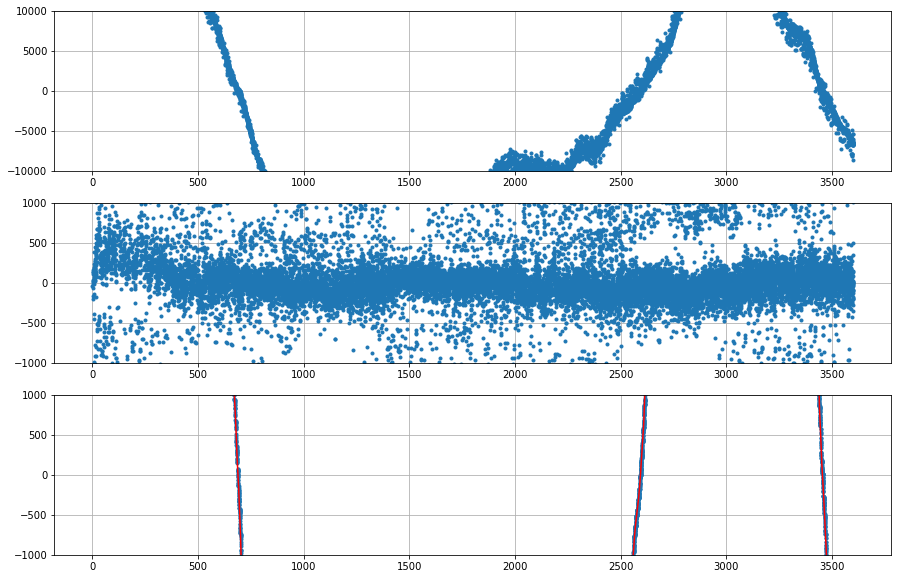

In [165]:
sss.check_result()

In [169]:
future = [669]

### Station 535

In [167]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(535)

sss.prepare_data(tracks, st, 535, 20000)
sss.optimize()

Median error: 44.55m using s=2.5e-12
Max time gap: 4.499s
Delta distance: 37.41m


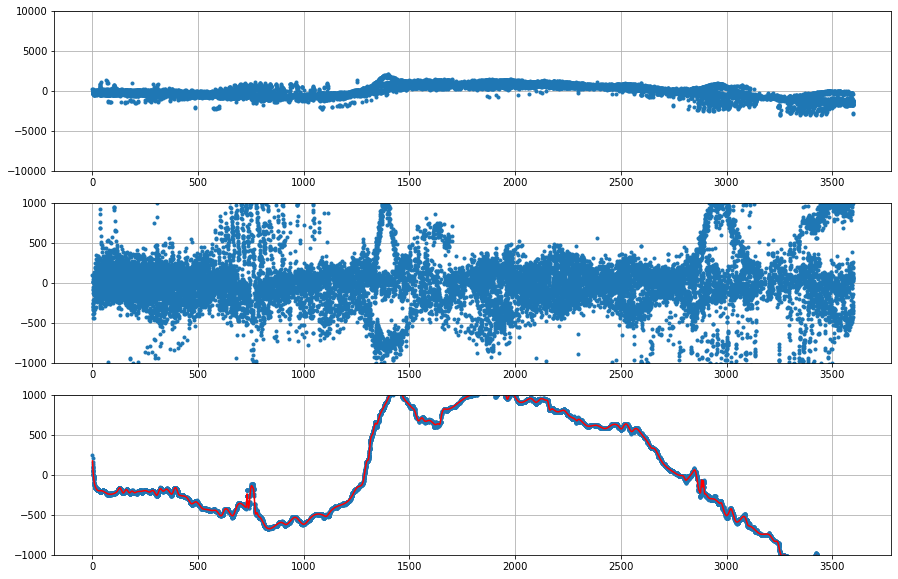

In [168]:
sss.check_result()

In [170]:
future += [535]

In [171]:
sss = another_run(200, bad + last_order, future, max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/31 [00:00<?, ?it/s]

Good station 587: error=28.32m, distance=26.09m
Good station 587: error=28.24m, distance=2.755m


  3%|▎         | 1/31 [00:57<28:33, 57.12s/it]

Good station 587: error=28.23m, distance=0.5185m
Good station 425: error=35.58m, distance=64.1m
Good station 425: error=35.58m, distance=0.4751m


 16%|█▌        | 5/31 [01:41<07:46, 17.94s/it]

Good station 425: error=35.45m, distance=0.1266m


 19%|█▉        | 6/31 [01:42<05:49, 14.00s/it]

Station 597 has less than 15000 points, skip


 29%|██▉       | 9/31 [02:03<03:50, 10.47s/it]

Station 165: Large time gap of 177.5, error 27.42m, skip


 32%|███▏      | 10/31 [02:04<03:03,  8.75s/it]

Station 698 has less than 15000 points, skip
Good station 604: error=27.32m, distance=11.44m
Good station 604: error=27.17m, distance=2.512m


 35%|███▌      | 11/31 [02:52<05:42, 17.10s/it]

Good station 604: error=27.2m, distance=0.3246m


 61%|██████▏   | 19/31 [02:53<01:00,  5.01s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 31/31 [02:53<00:00,  5.60s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 210


### Station 165

In [176]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(165)

sss.prepare_data(tracks, st, 165, 20000)
sss.optimize()

Median error: 27.54m using s=8e-12
Max time gap: 177.5s
Delta distance: 38.46m


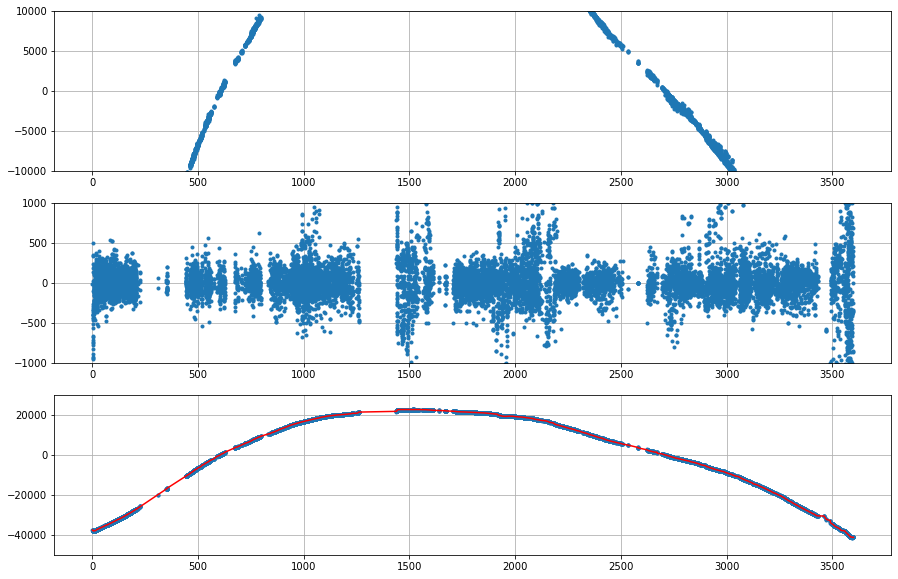

In [177]:
sss.check_result(ylim3=[-5e4, 3e4])

In [178]:
sss.save()

In [179]:
sss = another_run(200, bad + last_order, future, max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/27 [00:00<?, ?it/s]

Good station 293: error=29.04m, distance=20.28m
Good station 293: error=28.91m, distance=1.482m


  4%|▎         | 1/27 [00:44<19:25, 44.81s/it]

Good station 293: error=28.87m, distance=1.07m
Good station 600: error=27.43m, distance=19.33m
Good station 600: error=27.17m, distance=1.295m


  7%|▋         | 2/27 [02:29<33:21, 80.06s/it]

Good station 600: error=27.11m, distance=0.9668m


 19%|█▊        | 5/27 [02:30<08:26, 23.00s/it]

Station 597 has less than 15000 points, skip
Good station 319: error=21.55m, distance=17.09m
Good station 319: error=21.51m, distance=0.6789m


 22%|██▏       | 6/27 [03:19<10:22, 29.63s/it]

Good station 319: error=21.53m, distance=0.5326m
Good station 452: error=30.57m, distance=8.652m
Good station 452: error=30.65m, distance=2.632m


 26%|██▌       | 7/27 [04:07<11:30, 34.51s/it]

Good station 452: error=30.56m, distance=0.8094m


 30%|██▉       | 8/27 [04:08<08:01, 25.32s/it]

Station 698 has less than 15000 points, skip


 59%|█████▉    | 16/27 [04:09<01:07,  6.15s/it]

Station 711 has less than 15000 points, skip


 78%|███████▊  | 21/27 [04:24<00:29,  4.93s/it]

Bad station: 574: error=42.29m


100%|██████████| 27/27 [04:25<00:00,  9.83s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 215


### Station 574

In [185]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(574)

sss.prepare_data(tracks, st, 574, 20000)
sss.optimize()

Median error: 42.2m using s=1.45e-11
Max time gap: 3.126s
Delta distance: 0.01804m


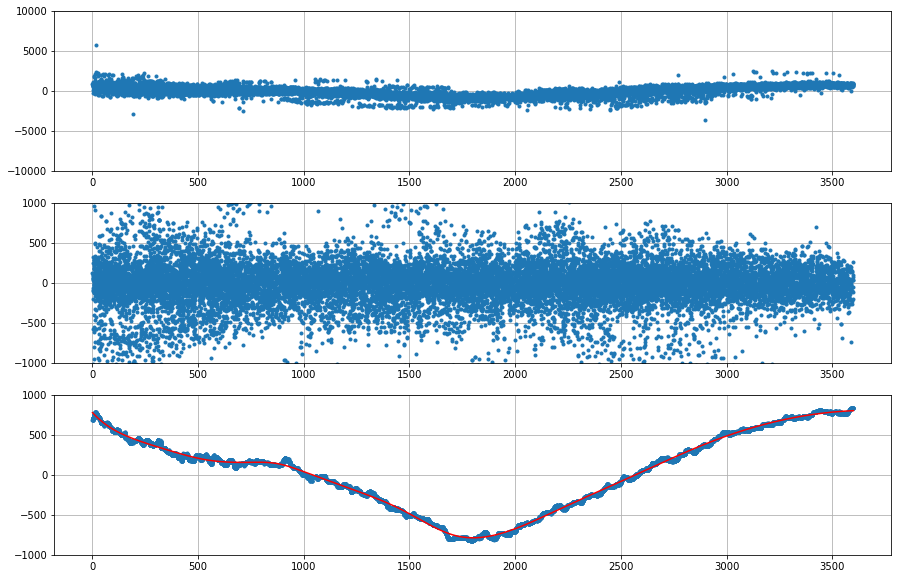

In [186]:
sss.check_result()

In [182]:
sss.save()

In [187]:
sss = another_run(200, bad + last_order, future, max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/22 [00:00<?, ?it/s]

Good station 87: error=32.72m, distance=6.771m
Good station 87: error=32.83m, distance=0.7284m


  9%|▉         | 2/22 [01:27<14:37, 43.89s/it]

Good station 87: error=32.94m, distance=0.8543m


 14%|█▎        | 3/22 [01:28<08:14, 26.04s/it]

Station 597 has less than 15000 points, skip


 18%|█▊        | 4/22 [01:29<05:00, 16.72s/it]

Station 698 has less than 15000 points, skip


 45%|████▌     | 10/22 [01:43<01:09,  5.77s/it]

Bad station: 565: error=40.32m


 59%|█████▉    | 13/22 [01:44<00:34,  3.79s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 22/22 [01:44<00:00,  4.77s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 217


### Station 565

In [188]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(565)

sss.prepare_data(tracks, st, 565, 20000)
sss.optimize()

Median error: 40.15m using s=3.5e-12
Max time gap: 3.384s
Delta distance: 39.61m


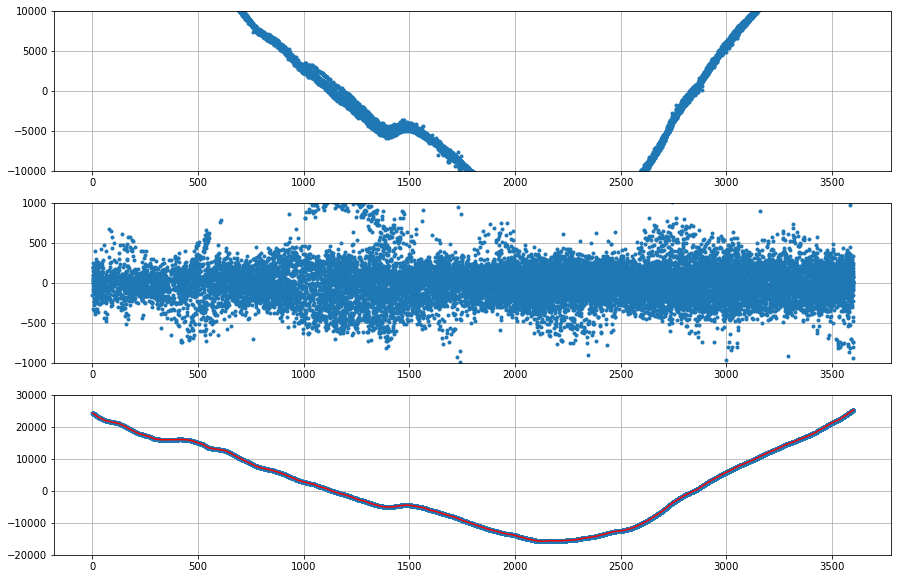

In [191]:
sss.check_result(ylim3=[-2e4, 3e4])

In [192]:
sss.save()

In [193]:
sss = another_run(200, bad + last_order, [], max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/22 [00:00<?, ?it/s]

Good station 251: error=25.98m, distance=24.16m
Good station 251: error=25.91m, distance=1.347m


  5%|▍         | 1/22 [01:00<21:14, 60.68s/it]

Good station 251: error=25.92m, distance=1.744m
Good station 669: error=40.0m, distance=32.08m
Good station 669: error=40.16m, distance=5.846m


  9%|▉         | 2/22 [02:50<29:48, 89.43s/it]

Good station 669: error=40.46m, distance=2.937m


 14%|█▎        | 3/22 [03:05<17:32, 55.38s/it]

Bad station: 535: error=44.99m


 18%|█▊        | 4/22 [03:06<10:10, 33.93s/it]

Station 597 has less than 15000 points, skip


 23%|██▎       | 5/22 [03:07<06:15, 22.08s/it]

Station 698 has less than 15000 points, skip


 59%|█████▉    | 13/22 [03:07<00:39,  4.36s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 22/22 [03:08<00:00,  8.55s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 220


In [195]:
# Reduce number of required stations from 3 to 2

sss = another_run(200, bad + last_order, future, max_err=40, N=15000, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  5%|▌         | 1/19 [00:01<00:18,  1.01s/it]

Station 597 has less than 15000 points, skip


 11%|█         | 2/19 [00:02<00:16,  1.00it/s]

Station 698 has less than 15000 points, skip


 16%|█▌        | 3/19 [00:02<00:14,  1.10it/s]

Station 705 has less than 15000 points, skip
Good station 683: error=31.51m, distance=60.42m
Good station 683: error=31.23m, distance=5.094m


 21%|██        | 4/19 [02:05<12:12, 48.84s/it]

Good station 683: error=31.15m, distance=0.5357m


 26%|██▋       | 5/19 [02:05<07:20, 31.43s/it]

Station 84 has less than 15000 points, skip
Good station 264: error=31.15m, distance=21.27m
Good station 264: error=31.29m, distance=0.7414m


 37%|███▋      | 7/19 [04:33<10:37, 53.09s/it]

Good station 264: error=31.39m, distance=1.118m


 53%|█████▎    | 10/19 [04:34<03:49, 25.53s/it]

Station 711 has less than 15000 points, skip


 68%|██████▊   | 13/19 [04:35<01:28, 14.72s/it]

Station 608 has less than 15000 points, skip


 74%|███████▎  | 14/19 [04:35<01:01, 12.35s/it]

Station 135 has less than 15000 points, skip


 84%|████████▍ | 16/19 [04:36<00:25,  8.45s/it]

Station 309 has less than 15000 points, skip


100%|██████████| 19/19 [04:36<00:00, 14.57s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 222


In [196]:
sss = another_run(100, bad + last_order, future, max_err=40, N=15000, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  4%|▎         | 1/27 [00:42<18:25, 42.52s/it]

Station 698: Large time gap of 187.3, error 26.19m, skip


  7%|▋         | 2/27 [01:07<13:28, 32.33s/it]

Station 597: Large time gap of 179.7, error 23.26m, skip


 11%|█         | 3/27 [01:09<07:18, 18.28s/it]

Station 705 has less than 15000 points, skip
Good station 603: error=36.73m, distance=25.37m
Good station 603: error=36.63m, distance=0.1253m


 15%|█▍        | 4/27 [02:08<13:14, 34.53s/it]

Good station 603: error=36.68m, distance=1.953m


 19%|█▊        | 5/27 [02:09<08:12, 22.39s/it]

Station 84 has less than 15000 points, skip


 22%|██▏       | 6/27 [02:10<05:14, 14.97s/it]

Station 282 has less than 15000 points, skip


 26%|██▌       | 7/27 [02:11<03:28, 10.41s/it]

Station 287 has less than 15000 points, skip


 30%|██▉       | 8/27 [02:11<02:17,  7.21s/it]

Station 493 has less than 15000 points, skip


 37%|███▋      | 10/27 [02:11<01:05,  3.87s/it]

Station 239 has less than 15000 points, skip


 44%|████▍     | 12/27 [02:13<00:39,  2.62s/it]

Station 711 has less than 15000 points, skip


 52%|█████▏    | 14/27 [02:13<00:22,  1.75s/it]

Station 606 has less than 15000 points, skip


 56%|█████▌    | 15/27 [02:14<00:18,  1.54s/it]

Station 682 has less than 15000 points, skip


 59%|█████▉    | 16/27 [02:15<00:14,  1.32s/it]

Station 608 has less than 15000 points, skip


 63%|██████▎   | 17/27 [02:16<00:11,  1.17s/it]

Station 318 has less than 15000 points, skip


 67%|██████▋   | 18/27 [02:17<00:10,  1.17s/it]

Station 33 has less than 15000 points, skip


 70%|███████   | 19/27 [02:18<00:09,  1.24s/it]

Station 135 has less than 15000 points, skip


 74%|███████▍  | 20/27 [02:20<00:09,  1.34s/it]

Station 506 has less than 15000 points, skip


 78%|███████▊  | 21/27 [02:23<00:11,  1.92s/it]

Station 309 has less than 15000 points, skip


 81%|████████▏ | 22/27 [02:23<00:07,  1.47s/it]

Station 30 has less than 15000 points, skip


 85%|████████▌ | 23/27 [02:25<00:05,  1.44s/it]

Station 230 has less than 15000 points, skip


 89%|████████▉ | 24/27 [02:27<00:04,  1.57s/it]

Station 35 has less than 15000 points, skip


 93%|█████████▎| 25/27 [02:27<00:02,  1.23s/it]

Station 609 has less than 15000 points, skip


100%|██████████| 27/27 [02:29<00:00,  5.54s/it]

Station 380 has less than 15000 points, skip
Number of synchronized stations= 223


### Station 698

In [199]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(698)

sss.prepare_data(tracks, st, 698, 20000)
sss.optimize()

Median error: 26.2m using s=3.5e-12
Max time gap: 187.3s
Delta distance: 20.6m


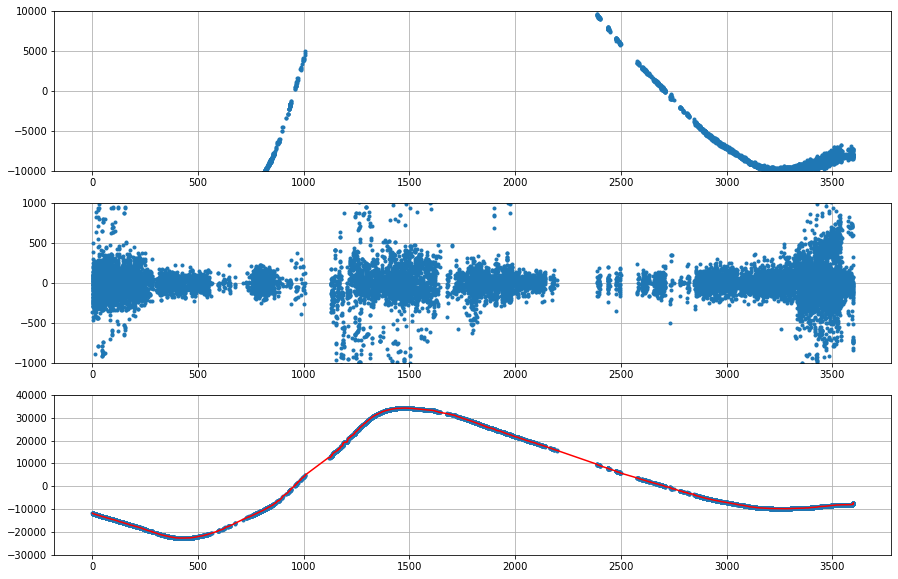

In [200]:
sss.check_result(ylim3=[-3e4, 4e4])

In [201]:
sss.save()

### Station 597

In [205]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(597)

sss.prepare_data(tracks, st, 597, 20000)
sss.optimize()

Median error: 23.02m using s=2e-12
Max time gap: 179.7s
Delta distance: 0.07657m


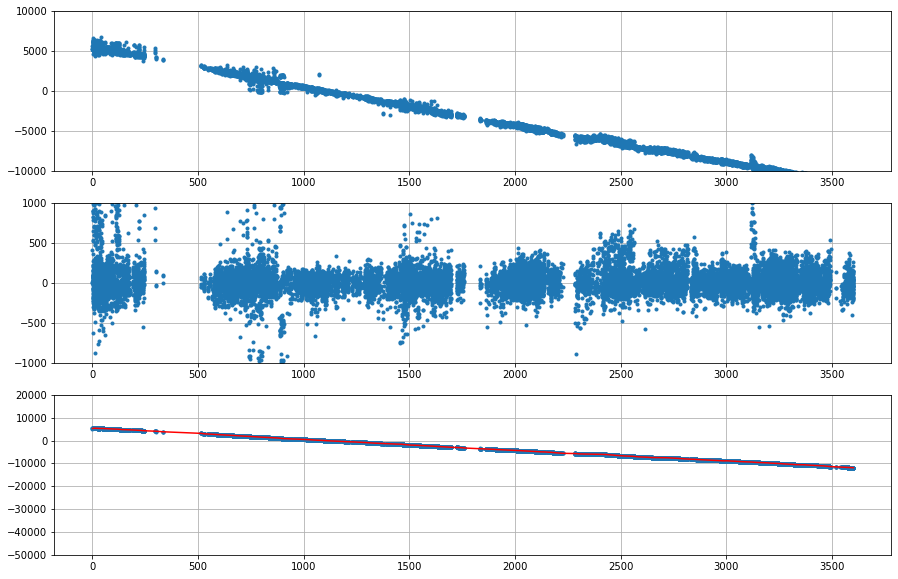

In [206]:
sss.check_result(ylim3=[-5e4, 2e4])

In [207]:
sss.save()

In [210]:
sss = another_run(100, bad + last_order, future, max_err=40, N=7500, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  4%|▍         | 1/24 [00:21<08:17, 21.61s/it]

Station 705: Large time gap of 56.9, error 24.19m, skip


  8%|▊         | 2/24 [00:45<08:27, 23.05s/it]

Station 84: Large time gap of 158.1, error 11.17m, skip


 12%|█▎        | 3/24 [00:46<04:27, 12.75s/it]

Station 282 has less than 7500 points, skip


 17%|█▋        | 4/24 [00:46<02:39,  7.99s/it]

Station 287 has less than 7500 points, skip


 21%|██        | 5/24 [00:47<01:39,  5.23s/it]

Station 493 has less than 7500 points, skip


 29%|██▉       | 7/24 [00:47<00:45,  2.67s/it]

Station 239 has less than 7500 points, skip


 38%|███▊      | 9/24 [01:50<03:40, 14.72s/it]

Station 711: Large time gap of 228.2, error 34.74m, skip


 46%|████▌     | 11/24 [01:50<02:00,  9.27s/it]

Station 606 has less than 7500 points, skip


 50%|█████     | 12/24 [01:51<01:29,  7.46s/it]

Station 682 has less than 7500 points, skip


 54%|█████▍    | 13/24 [01:51<01:04,  5.84s/it]

Station 608 has less than 7500 points, skip


 58%|█████▊    | 14/24 [01:52<00:45,  4.55s/it]

Station 318 has less than 7500 points, skip


 62%|██████▎   | 15/24 [01:53<00:32,  3.62s/it]

Station 33 has less than 7500 points, skip
Good station 135: error=39.31m, distance=82.77m
Good station 135: error=39.0m, distance=1.807m


 67%|██████▋   | 16/24 [02:11<01:00,  7.59s/it]

Good station 135: error=39.02m, distance=0.9957m


 71%|███████   | 17/24 [02:13<00:41,  6.00s/it]

Station 506 has less than 7500 points, skip


 75%|███████▌  | 18/24 [02:22<00:41,  6.92s/it]

Station 309: Large time gap of 106.6, error 23.49m, skip


 79%|███████▉  | 19/24 [02:23<00:25,  5.01s/it]

Station 30 has less than 7500 points, skip


 83%|████████▎ | 20/24 [02:24<00:15,  3.90s/it]

Station 230 has less than 7500 points, skip


 88%|████████▊ | 21/24 [02:32<00:15,  5.10s/it]

Bad station: 35: error=41.18m


 92%|█████████▏| 22/24 [02:32<00:07,  3.70s/it]

Station 609 has less than 7500 points, skip


100%|██████████| 24/24 [02:34<00:00,  6.43s/it]

Station 380 has less than 7500 points, skip
Number of synchronized stations= 226


### Station 705

In [220]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(705)

sss.prepare_data(tracks, st, 705, 20000)
sss.optimize()

Median error: 23.86m using s=6.5e-12
Max time gap: 56.9s
Delta distance: 0.09778m


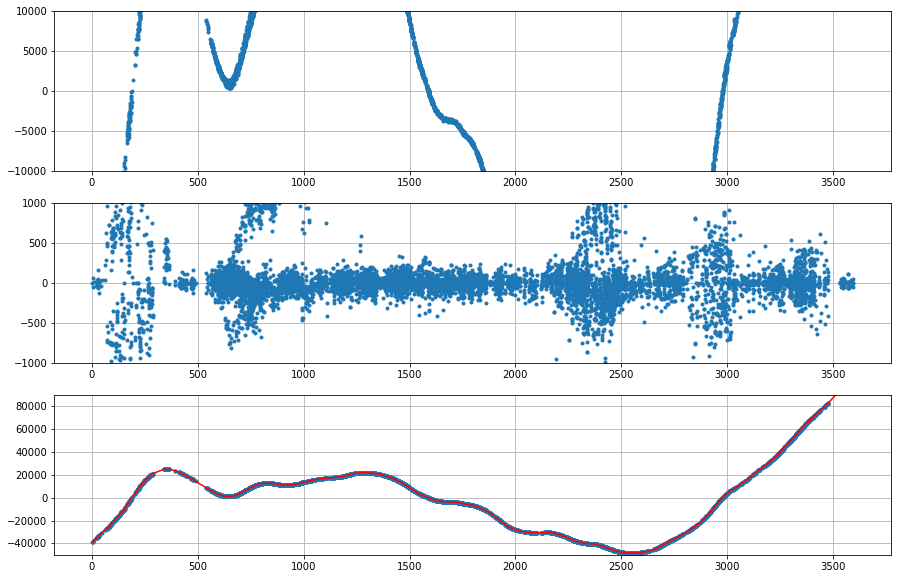

In [221]:
sss.check_result(ylim3=[-5e4, 9e4])

In [222]:
sss.save()

### Station 84

In [230]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(84)

sss.prepare_data(tracks, st, 84, 20000)
sss.optimize()

Median error: 10.77m using s=2e-12
Max time gap: 158.1s
Delta distance: 0.0m


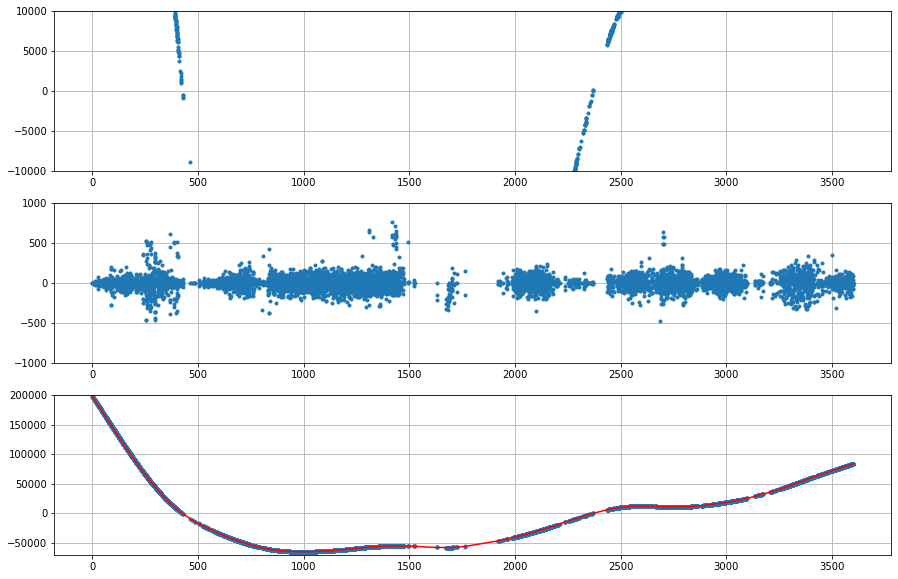

In [231]:
sss.check_result(ylim3=[-7e4, 2e5])

In [229]:
sss.save()

### Station 711

In [232]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(711)

sss.prepare_data(tracks, st, 711, 20000)
sss.optimize()

Median error: 39.08m using s=2.05e-11
Max time gap: 228.2s
Delta distance: 4.152e+06m


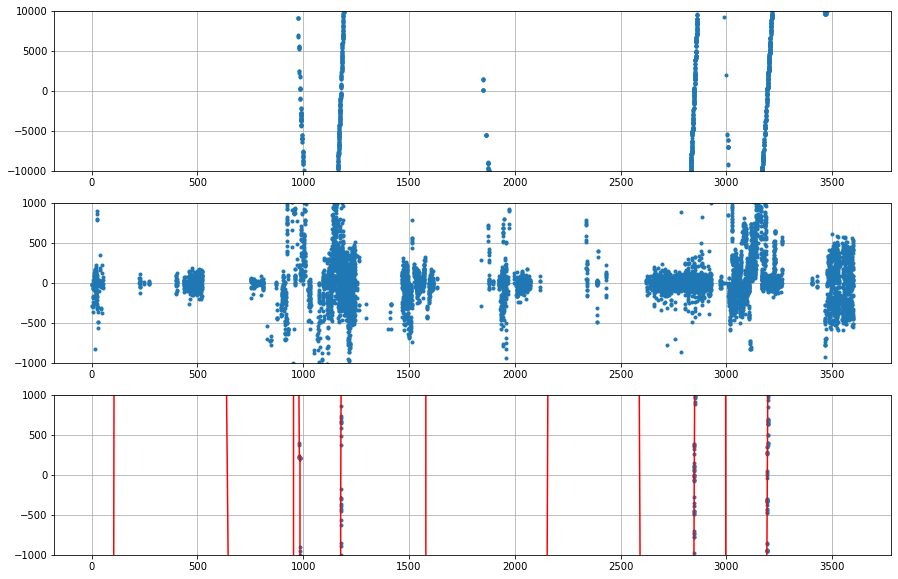

In [233]:
sss.check_result()

In [234]:
## This station isn't useful, skip it

### Station 309

In [239]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(309)

sss.prepare_data(tracks, st, 309, 20000)
sss.optimize()

Median error: 23.08m using s=2e-12
Max time gap: 106.6s
Delta distance: 20.52m


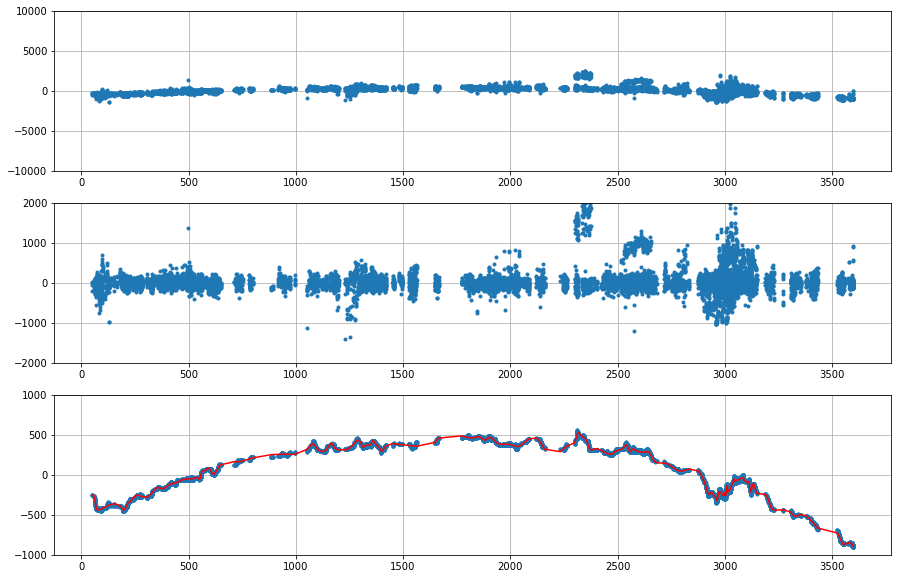

In [242]:
sss.check_result(ylim2=[-2e3, 2e3])

In [243]:
sss.save()

In [244]:
## Correct gaps manually to exclude some non reliable time range

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st_params['309']['gaps']

[[0, 52.634486364074974],
 [647.8155678551345, 882.7647517283494],
 [992.9151513280106, 1052.0857237269122],
 [1199.0202325801458, 1229.0291388231053],
 [1419.6035532312935, 1774.4455710616328],
 [2085.242610977114, 2300.554296185678],
 [2680.708936764671, 2718.812412213198],
 [2834.1648036935408, 2877.349595637428],
 [3149.064222326709, 3307.536605134031],
 [3435.3166458329797, 3525.0961616435616]]

In [245]:
st_params['309']['gaps'] = [[0, 52.634486364074974],
                            [647.8155678551345, 882.7647517283494],
                            [992.9151513280106, 1052.0857237269122],
                            [1199.0202325801458, 1229.0291388231053],
                            [1419.6035532312935, 1774.4455710616328],
                            [2085.242610977114, 3600]]

with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

### Station 35

In [253]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(35)

sss.prepare_data(tracks, st, 35, 20000)
sss.optimize()

Median error: 41.25m using s=2e-12
Max time gap: 8.011s
Delta distance: 469.1m


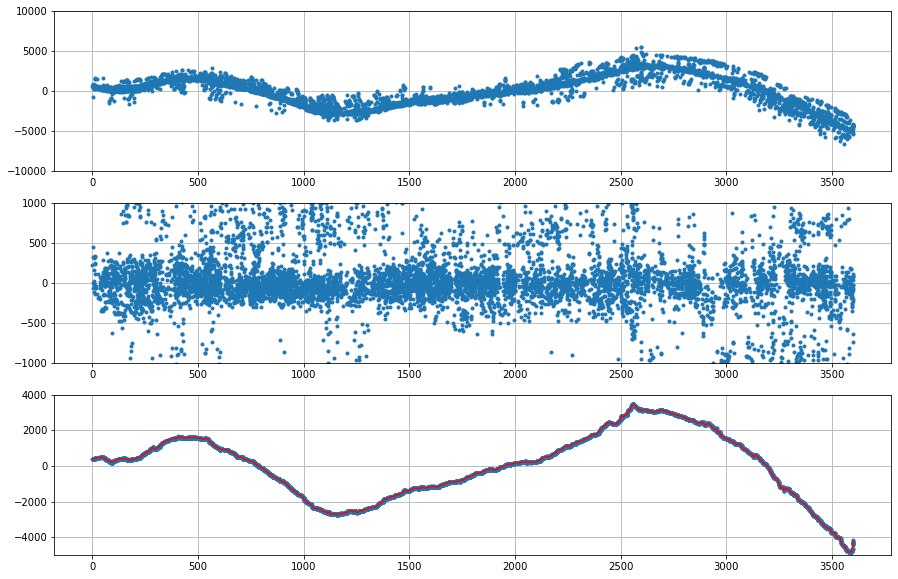

In [254]:
sss.check_result(ylim3=[-5e3, 4e3])

In [255]:
sss.save()

In [261]:
# Check all future stations

sss = another_run(100, bad, [], max_err=40, N=10000, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  3%|▎         | 1/32 [01:17<39:51, 77.14s/it]

Bad station: 357: error=51.04m


  6%|▋         | 2/32 [01:26<18:37, 37.26s/it]

Station 623: Large time gap of 172.4, error 28.75m, skip


  9%|▉         | 3/32 [01:42<13:23, 27.71s/it]

Bad station: 346: error=50.28m


 12%|█▎        | 4/32 [01:54<09:58, 21.37s/it]

Bad station: 535: error=47.29m


 16%|█▌        | 5/32 [02:16<09:45, 21.68s/it]

Station 478: Large time gap of 72.55, error 34.59m, skip


 19%|█▉        | 6/32 [08:43<1:03:15, 145.99s/it]

Bad station: 265: error=63.5m


 22%|██▏       | 7/32 [08:53<42:16, 101.44s/it]  

Station 423: Large time gap of 241.9, error 25.91m, skip


 25%|██▌       | 8/32 [08:54<27:43, 69.32s/it] 

Station 282 has less than 10000 points, skip


 28%|██▊       | 9/32 [08:55<18:21, 47.89s/it]

Station 287 has less than 10000 points, skip


 31%|███▏      | 10/32 [08:55<12:10, 33.22s/it]

Station 493 has less than 10000 points, skip


 34%|███▍      | 11/32 [09:06<09:16, 26.48s/it]

Station 439: Large time gap of 264.5, error 26.74m, skip


 41%|████      | 13/32 [11:30<15:06, 47.72s/it]

Bad station: 619: error=50.6m


 44%|████▍     | 14/32 [11:31<10:46, 35.89s/it]

Station 239 has less than 10000 points, skip


 50%|█████     | 16/32 [11:32<05:39, 21.23s/it]

Station 711 has less than 10000 points, skip


 56%|█████▋    | 18/32 [11:32<03:07, 13.38s/it]

Station 606 has less than 10000 points, skip


 59%|█████▉    | 19/32 [11:37<02:30, 11.60s/it]

Bad station: 30: error=nanm


 62%|██████▎   | 20/32 [12:01<02:53, 14.48s/it]

Station 268: Large time gap of 81.77, error 33.23m, skip


 69%|██████▉   | 22/32 [12:02<01:28,  8.89s/it]

Station 682 has less than 10000 points, skip


 72%|███████▏  | 23/32 [12:03<01:03,  7.05s/it]

Station 608 has less than 10000 points, skip


 75%|███████▌  | 24/32 [12:04<00:44,  5.55s/it]

Station 318 has less than 10000 points, skip


 78%|███████▊  | 25/32 [12:33<01:21, 11.68s/it]

Bad station: 33: error=45.93m


 81%|████████▏ | 26/32 [12:35<00:53,  8.99s/it]

Station 506 has less than 10000 points, skip


 84%|████████▍ | 27/32 [12:36<00:34,  6.89s/it]

Station 230 has less than 10000 points, skip


 91%|█████████ | 29/32 [12:37<00:11,  3.96s/it]

Station 609 has less than 10000 points, skip


100%|██████████| 32/32 [12:38<00:00, 23.71s/it]

Station 380 has less than 10000 points, skip


FileNotFoundError: [Errno 2] No such file or directory: 'stations_params2.json'

## Final check of the stations kept previously

### Station 357

In [263]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

sss = SingleStationSolver()
sss.find_new_stations(tracks, st, bad, 100)
st.add_station(357)

sss.prepare_data(tracks, st, 357, 20000)
sss.optimize()

100%|██████████| 2629/2629 [00:02<00:00, 1041.82it/s]


Median error: 50.54m using s=1.05e-11
Max time gap: 2.113s
Delta distance: 23.82m


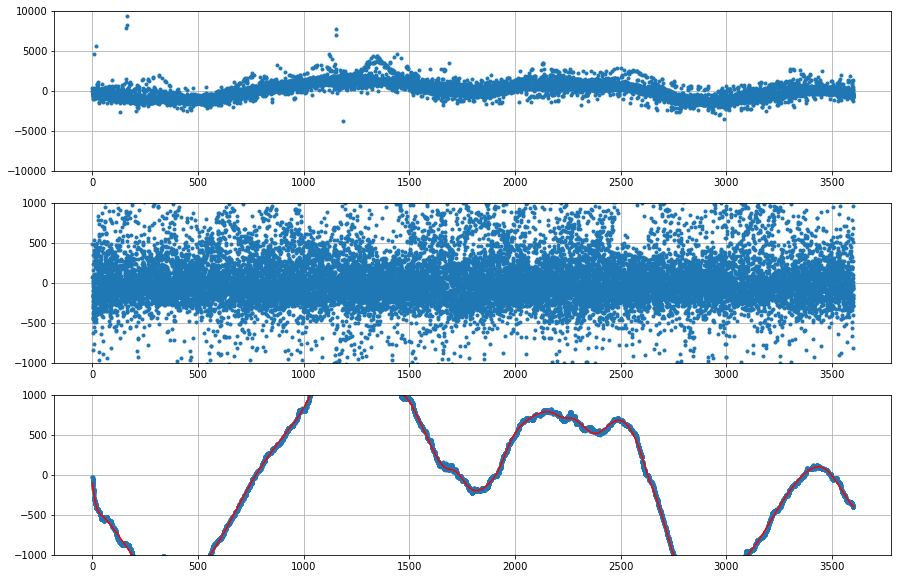

In [264]:
sss.check_result()

In [265]:
sss.save()

### Station 623

In [269]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(623)

sss.prepare_data(tracks, st, 623, 20000)
sss.optimize()

Median error: 28.89m using s=3e-12
Max time gap: 171.5s
Delta distance: 0.2262m


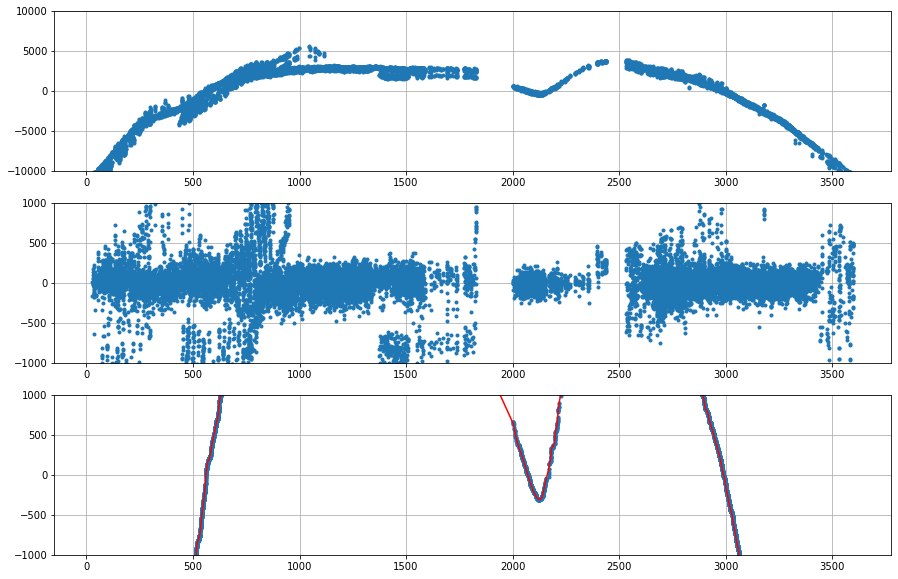

In [270]:
sss.check_result()

In [268]:
sss.save()

### Station 346

In [275]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(346)

sss.prepare_data(tracks, st, 346, 20000)
sss.optimize()

Median error: 48.98m using s=3e-12
Max time gap: 2.183s
Delta distance: 2.14m


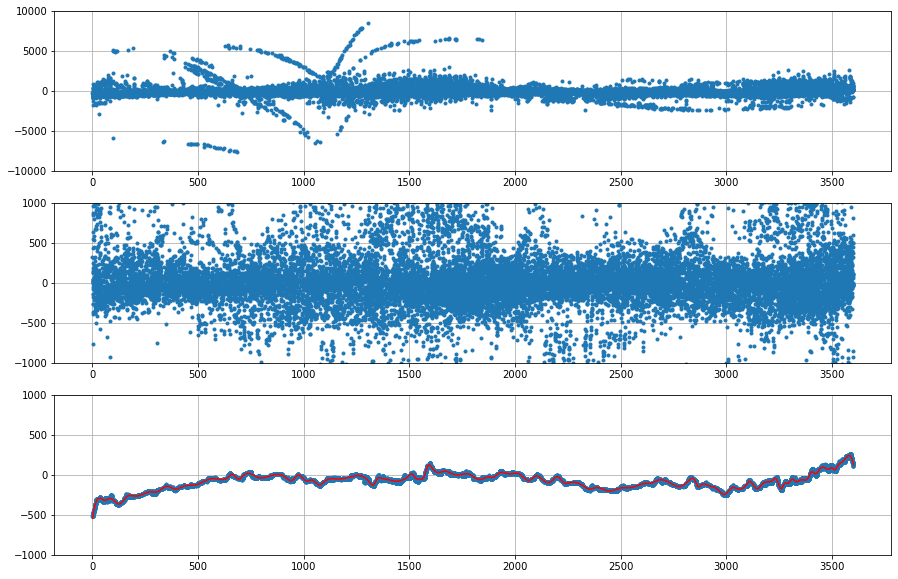

In [276]:
sss.check_result()

In [277]:
sss.save()

### Station 535

In [282]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(535)

sss.prepare_data(tracks, st, 535, 20000)
sss.optimize()

Median error: 46.13m using s=3e-12
Max time gap: 7.077s
Delta distance: 0.05935m


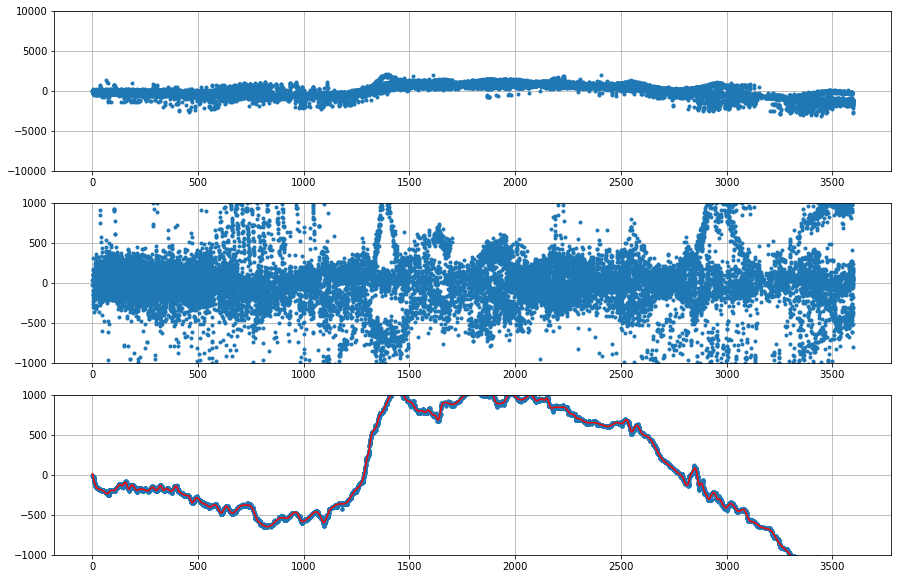

In [283]:
sss.check_result()

In [284]:
sss.save()

### Station 478

In [290]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(478)

sss.prepare_data(tracks, st, 478, 20000)
sss.optimize()

Median error: 34.61m using s=2e-12
Max time gap: 78.45s
Delta distance: 34.62m


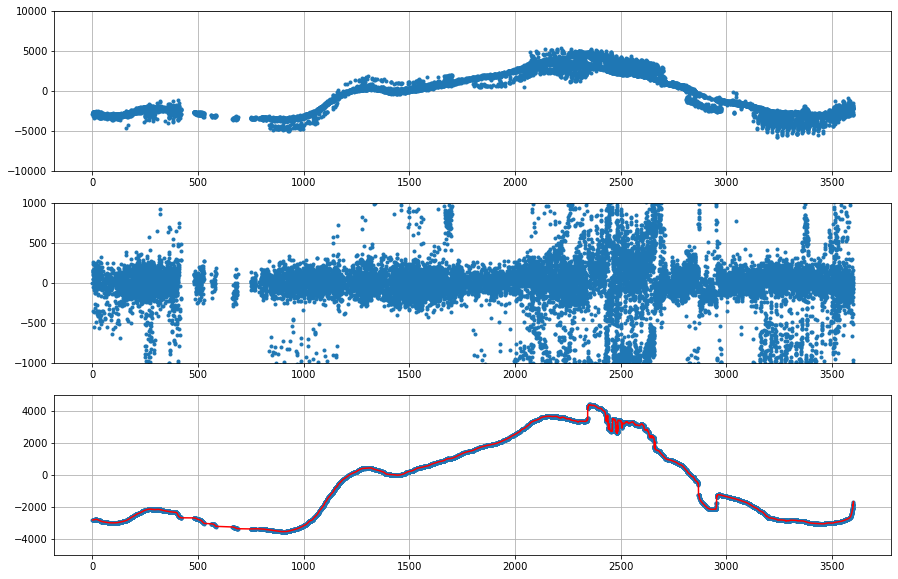

In [291]:
sss.check_result(ylim3=[-5e3, 5e3])

In [292]:
sss.save()

In [293]:
## Correct gaps manually to exclude some non reliable time range

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st_params['478']['gaps']

[[418.49321315630067, 750.3854760917937]]

In [294]:
st_params['478']['gaps'] = [[418.49321315630067, 750.3854760917937], [2300, 2700], [2850, 3000]]

with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

### Station 265

In [14]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(265)

sss.prepare_data(tracks, st, 265, 10000)
sss.optimize()

Median error: 62.4m using s=2.05e-11
Max time gap: 5.24s
Delta distance: 75.19m


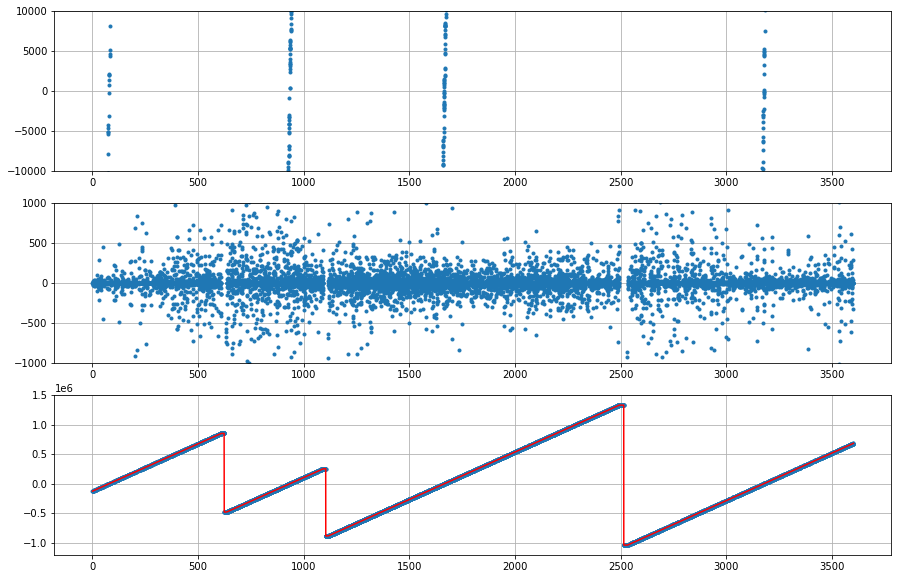

In [19]:
sss.check_result(ylim3=[-1.2e6, 1.5e6])

In [20]:
sss.save()

In [21]:
## Add gaps where drift sharply changes

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

ii = np.where(np.fabs(np.diff(st_params['265']['spl_coefs'])) > 0.001)[0]
jj = [ii[0]]

for i in range(1, len(ii)):
    #print(ii[i], ii[i-1])
    if ii[i] - ii[i-1] > 1:
        jj.append(ii[i])

gaps = []
## Add +-5s for each sharp change
for i in np.array(st_params['265']['spl_knots'])[jj]:
    gaps += [[max(i-5, 0), min(i+5, 3600)]]
gaps

[[619.0468574535861, 629.0468574535861],
 [1099.6190936958412, 1109.6190936958412],
 [2507.5367484924377, 2517.5367484924377]]

In [22]:
st_params['265']['gaps'] = [[619.0468574535861, 629.0468574535861],
                            [1099.6190936958412, 1109.6190936958412],
                            [2507.5367484924377, 2517.5367484924377]]

with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

### Correct gaps for station 669

In [27]:
st_params['669']['gaps'] = [[0, 500]]

with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

### Station 423

In [31]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(423)

sss.prepare_data(tracks, st, 423, 20000)
sss.optimize()

Median error: 25.98m using s=3e-12
Max time gap: 241.9s
Delta distance: 40.9m


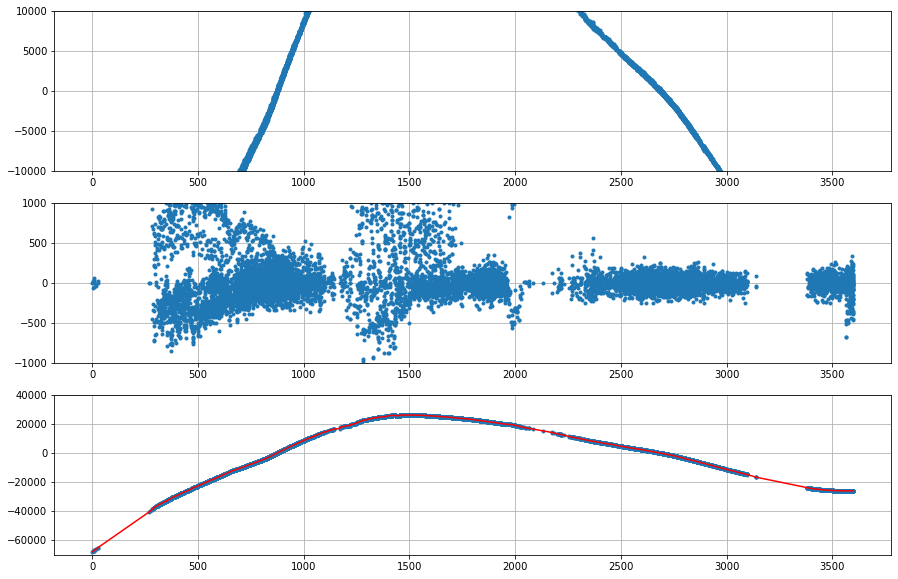

In [34]:
sss.check_result(ylim3=[-7e4, 4e4])

In [35]:
sss.save()

In [36]:
## Correct gaps manually to exclude some non reliable time range

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st_params['423']['gaps']

[[26.553456204386066, 270.414147352172],
 [1140.5490557716867, 1171.6900591715983],
 [2081.5622658307493, 2176.378914874923],
 [3096.462980443859, 3379.3105202255506]]

In [37]:
st_params['423']['gaps'] = [[0, 750]]

with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

### Station 439

In [41]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(439)

sss.prepare_data(tracks, st, 439, 20000)
sss.optimize()

Median error: 24.65m using s=2e-12
Max time gap: 262.5s
Delta distance: 34.2m


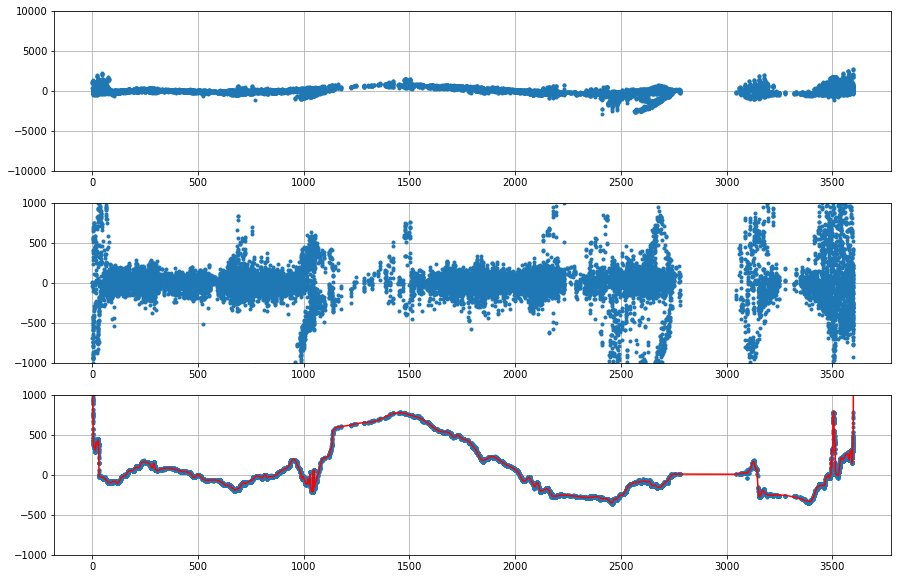

In [42]:
sss.check_result()

In [43]:
sss.save()

In [44]:
## Correct gaps manually to exclude some non reliable time range

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st_params['439']['gaps']

[[1177.421121592667, 1285.0642947805063],
 [2779.444445537382, 3043.9635101369004],
 [3245.783571639857, 3322.301487392732]]

In [45]:
st_params['439']['gaps'] = [[0, 40],
                            [1020, 1060],
                            [1177.421121592667, 1285.0642947805063],
                            [2779.444445537382, 3043.9635101369004],
                            [3245.783571639857, 3322.301487392732],
                            [3475, 3525],
                            [3560, 3600]]

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

### Station 619

In [51]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(619)

sss.prepare_data(tracks, st, 619, 20000)
sss.optimize()

Median error: 46.03m using s=2e-11
Max time gap: 8.63s
Delta distance: 47.95m


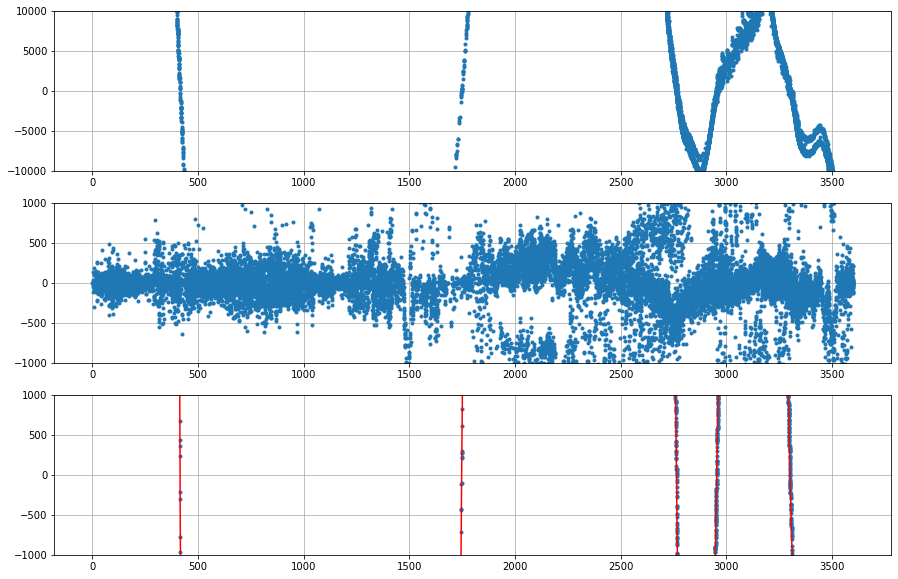

In [52]:
sss.check_result()

In [ ]:
sss.save()

In [62]:
## Correct gaps manually to exclude some non reliable time range

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st_params['619']['gaps'] = [[1000, 3600]]

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

### Station 268

In [54]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(268)

sss.prepare_data(tracks, st, 268, 20000)
sss.optimize()

Median error: 30.14m using s=2e-12
Max time gap: 81.49s
Delta distance: 481.2m


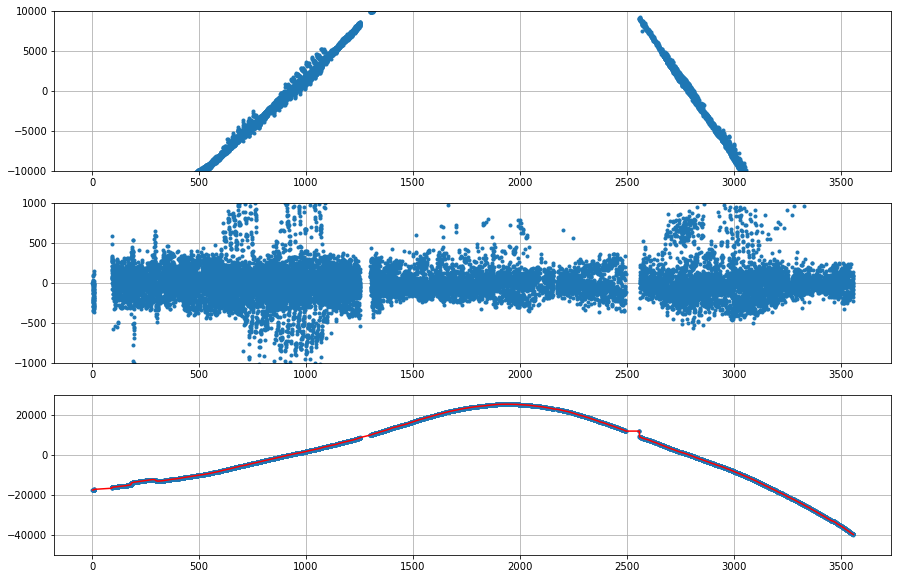

In [59]:
sss.check_result(ylim3=[-5e4, 3e4])

In [60]:
sss.save()

### Station 33

In [63]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params
st.add_station(33)

sss.prepare_data(tracks, st, 33, 20000)
sss.optimize()

Median error: 44.81m using s=7.5e-12
Max time gap: 208.3s
Delta distance: 1.878e+03m


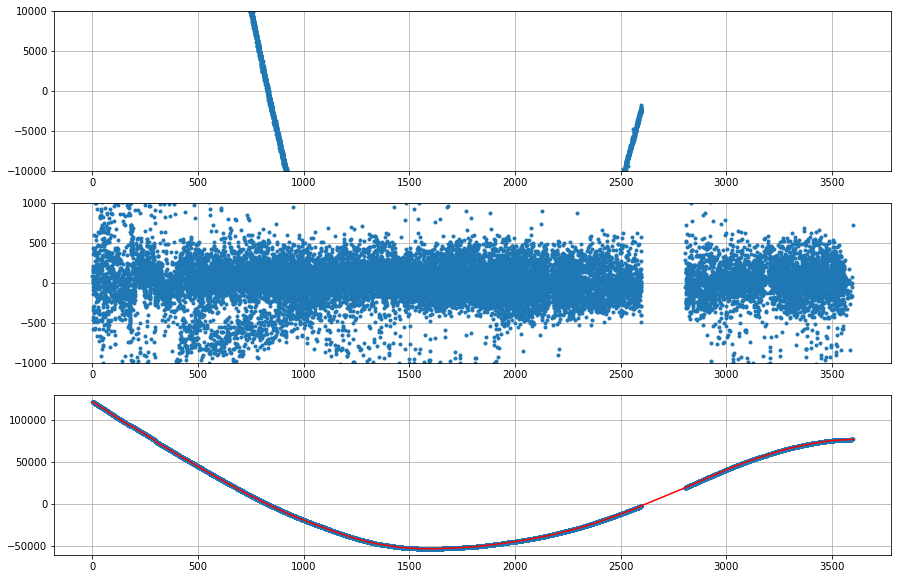

In [69]:
sss.check_result(ylim3=[-6e4, 1.3e5])

In [70]:
sss.save()

## Results

In [76]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

print('Total number of synchronized stations:', len(st_params))

Total number of synchronized stations: 241


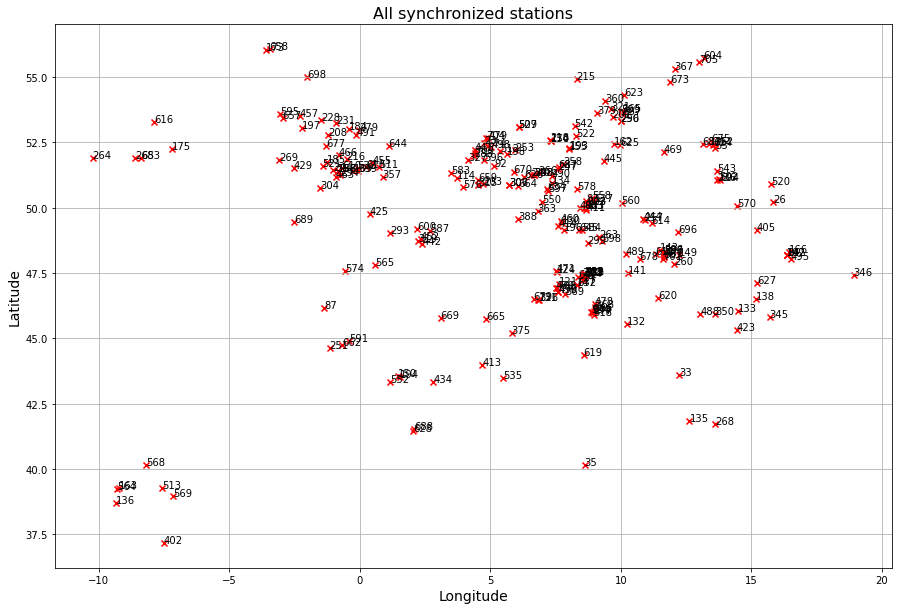

In [91]:
st = Stations([int(s) for s in st_params])
for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.plot()
_ = plt.title('All synchronized stations', fontsize=16)

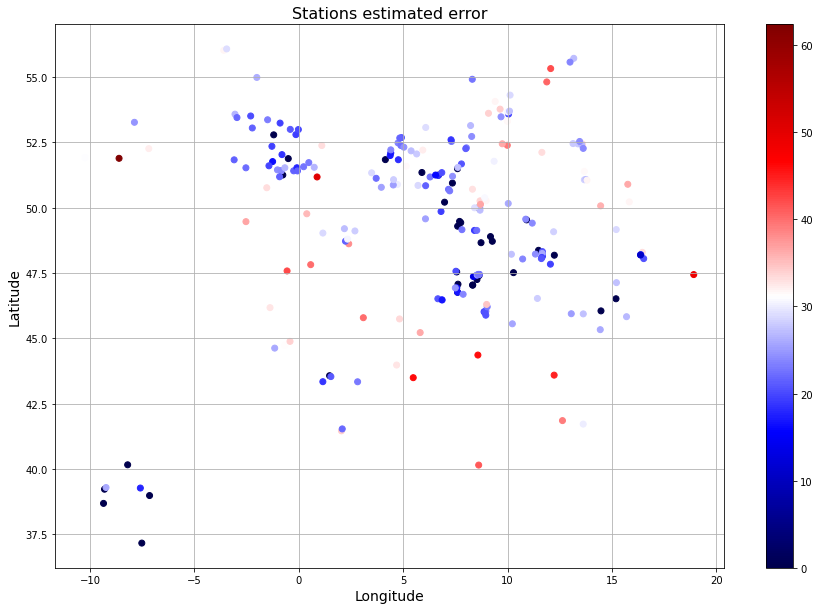

In [92]:
## Estimation error

lat, lon, err = [], [], []
for s in st_params:
    lat.append(st_params[s]['location'][0])
    lon.append(st_params[s]['location'][1])
    
    if 'med_error' in st_params[s]:
        err.append(st_params[s]['med_error'])
    else:
        err.append(0)
        
plt.scatter(lon, lat, c=err, cmap='seismic')

plt.title('Stations estimated error', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid()

_ = plt.colorbar()